# Imports

In [1]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021"
sys.path.append(CODE_DIR)

In [15]:
import os
import torch
import numpy as np
import pandas as pd
import pickle

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns; sns.set()

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *
from analysis.bda_models.bda_pixel_model_mnist import GenPixelModelMNIST
from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

from dataset_dataloader import get_n_data_samples_x_y

In [3]:
SAVE_DIR = "output_files"

SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/MNIST_surprisal_values.pt"

SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/MNIST_surprisal_dp_mixtures.pt"

SAVE_DP_COMP_KL_DISTS_FILE = f"{SAVE_DIR}/MNIST_dp_mixtures_kl_comp_dists.pt"

os.makedirs(SAVE_DIR, exist_ok=True)

In [4]:
FIT_AND_COMPUTE_SURPRISAL_VALS = False

PERFORM_MODEL_CHECKS = False

FIT_SURPRISAL_DPS = False

In [5]:
run_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)
run_df = run_df[run_df.image_or_language == "image"]

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(run_df.index)) \
                                  & (global_stats_df.phase == "valid")]

run_df.head()

objective  l_rate dataset  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T        INFO-VAE     0.1  bmnist   
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++   INFO-VAE     0.1  bmnist   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T       INFO-VAE     0.1  bmnist   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++  INFO-VAE     0.1  bmnist   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T      INFO-VAE     0.1  bmnist   

                                             image_or_language  beta_beta  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T                   image        0.0   
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++              image        0.0   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T                  image        0.0   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++             image        0.0   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T                 image        0.0   

                                              free_bits  mdr_value  l_mmd  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T                0          0      1   
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++           0          0      1   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T               0          0     10   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++          0          0     10   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T              0          0    100   

                                                           decoder  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T        basic_deconv_decoder   
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++      cond_pixel_cnn_pp   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T       basic_deconv_decoder   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++     cond_pixel_cnn_pp   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T      basic_deconv_decoder   

                                                                                       run_name  
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T        (inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2...  
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++   (inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2...  
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T       (20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd...  
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++  (20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd...  
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T      (inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2...

# Get some MNIST data

In [6]:
if FIT_AND_COMPUTE_SURPRISAL_VALS or PERFORM_MODEL_CHECKS:
    N_DATA_SAMPLES = 1000

    train_x, train_y = get_n_data_samples_x_y(image_dataset_name="bmnist", image_or_language="image", 
                                              N_samples=N_DATA_SAMPLES, phase="train")
    valid_x, valid_y = get_n_data_samples_x_y(image_dataset_name="bmnist", image_or_language="image", 
                                              N_samples=N_DATA_SAMPLES, phase="valid")

    VALID_OBS_X = valid_x.flatten(start_dim=1).numpy()
    VALID_OBS_Y = valid_y.long().numpy()

    TRAIN_OBS_X = train_x.flatten(start_dim=1).numpy()
    TRAIN_OBS_Y = train_y.long().numpy()

# Generative Pixel Model MNIST (train & validation)

The generative model is a DP Mixture beta bernoulli model with 10 components (for the 10 digits).

In [7]:
if FIT_AND_COMPUTE_SURPRISAL_VALS or PERFORM_MODEL_CHECKS:
    NUM_SAMPLES = 1000

    # No need to pass chains and warmup because it is an exact model
    gen_model = GenPixelModelMNIST(
        obs_x=TRAIN_OBS_X, 
        obs_y=TRAIN_OBS_Y, 
        num_samples=NUM_SAMPLES, 
    )

# Gather samples from disk

In [8]:
if FIT_AND_COMPUTE_SURPRISAL_VALS or PERFORM_MODEL_CHECKS:

    EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
    
    SAMPLE_FILE = f"generative-samples.pt"
    CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

    MAX_SAMPLES_PER_MODEL = 500 # 500 is currently its max

    model_samples = dict()

    for idx, run_name in enumerate(os.listdir(EXPORT_DIR)):
        if run_name in run_df.run_name.values:
            
            clean_name = run_df[run_df.run_name == run_name].index.values[0]
            save_dir = f"{EXPORT_DIR}/{run_name}"
            
            if (os.path.exists(f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}") and os.path.exists(f"{save_dir}/{SAMPLE_FILE}")):
                # Dict with keys conditional_x, conditional_y
                conditional_samples = torch.load(f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}")["valid"]
                unconditional_samples = torch.load(f"{save_dir}/{SAMPLE_FILE}")

                conditional_x = conditional_samples["cond_sample_x"]
                condition_y = conditional_samples["original_y"]
                unconditional_x = unconditional_samples["x"]

                if len(conditional_x) < MAX_SAMPLES_PER_MODEL:
                    print(f"not enough conditional_x samples {len(conditional_x)} < {MAX_SAMPLES_PER_MODEL}")

                if len(unconditional_x) < MAX_SAMPLES_PER_MODEL:
                    print(f"not enough unconditional_x samples {len(unconditional_x)} < {MAX_SAMPLES_PER_MODEL}")

                model_samples[clean_name] = dict(
                    unconditional_x=unconditional_x[:MAX_SAMPLES_PER_MODEL].reshape(-1, 28*28).numpy(),
                    conditional_x=conditional_x[:MAX_SAMPLES_PER_MODEL].reshape(-1, 28*28).numpy(),
                    condition_y=condition_y[:MAX_SAMPLES_PER_MODEL].long().numpy()
                )

                print(idx, clean_name)
                print("unconditional_x", model_samples[clean_name]["unconditional_x"].shape)
                print("conditional_x", model_samples[clean_name]["conditional_x"].shape)
                print("condition_y", model_samples[clean_name]["condition_y"].shape, end='\n\n')
                
            else:
                print("Files missing, skip.")

    model_samples["data_group"] = dict(
        unconditional_x=VALID_OBS_X,
        conditional_x=VALID_OBS_X,
        condition_y=VALID_OBS_Y)


## Collect & plot some posterior predictive samples

In [9]:
if PERFORM_MODEL_CHECKS:

    ncols = 5
    nrows = 2
    nplots = nrows * ncols

    for digit in range(10):
        obs_ys = np.ones(nplots).astype(int) * digit
        rng_key, rng_key_ = random.split(gen_model.rng_key)
        cond_posterior_pred = gen_model.conditional_posterior_predictive(obs_ys=obs_ys).sample(key=rng_key_)

        fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))

        for i in range(nplots): 
            c = i % ncols
            r = i // ncols
            ax[r, c].imshow(np.array(cond_posterior_pred[i].reshape(28, 28)), cmap="Greys")
            ax[r, c].grid("off")
            ax[r, c].set_xticks([])
            ax[r, c].set_yticks([])

        plt.show()

# Sample from conditional posterior predictive

In [10]:
if PERFORM_MODEL_CHECKS:
    npost_samples = 100
    samples = dict()

    for digit in range(10):
        print(f"{digit:2d}/10", end="\r")
        valid_y_digit = VALID_OBS_Y[VALID_OBS_Y == digit]
        rng_key, rng_key_ = random.split(gen_model.rng_key)

        # N_post_samples, N_data, 784
        cond_posterior_pred = gen_model.conditional_posterior_predictive(obs_ys=valid_y_digit).sample(
            key=rng_key_, sample_shape=(npost_samples,))

        samples[digit] = cond_posterior_pred

# Plot true versus sampled digit

In [11]:
if PERFORM_MODEL_CHECKS:
    fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(3*3, 3*10))

    for k in range(10):
        # 2D [N, 786]
        true_digits = VALID_OBS_X[VALID_OBS_Y == k]
        avg_true_digit = true_digits.mean(axis=0)

        # 3D [S, N, 786]
        sampeld_digits = samples[k]
        avg_sampled_digit = sampeld_digits.mean(axis=0).mean(axis=0)

        ax[k, 0].imshow(avg_true_digit.reshape(28, 28), cmap="Greys")
        ax[k, 0].set_title(f"Avg. true digit {k}")
        ax[k, 1].imshow(avg_sampled_digit.reshape(28, 28), cmap="Greys")
        ax[k, 1].set_title(f"Avg. sampled digit {k}")
        ax[k, 2].imshow(np.abs(avg_true_digit-avg_sampled_digit).reshape(28, 28), cmap="Greys")
        ax[k, 2].set_title(f"Abs dif. between\navg. true and sampled digit {k}")

        for i in range(3):
            ax[k, i].grid("off")
            ax[k, i].set_xticks([])
            ax[k, i].set_yticks([])


# Posterior predictive checks

In [12]:

if PERFORM_MODEL_CHECKS:
    fig, ax = plt.subplots(ncols=4, nrows=10, figsize=(3*4, 2*10))

    hist_kwargs = dict(bins=30, density=True, alpha=0.8)
    line_kwargs = dict(linestyle='--')

    for k in range(10):
        print(f"{k:2d}/10", end="\r")

        # 2D [N, 786]
        true_digits = VALID_OBS_X[VALID_OBS_Y == k]

        # 3D [S, N, 786]
        sampled_digits = samples[k]
        sampled_digits_2d = sampled_digits.reshape(-1, 28*28)

        # Hist of pixel means (hist over all pixels)
        ax[k, 0].hist(sampled_digits_2d.mean(axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
        ax[k, 0].hist(true_digits.mean(axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
        ax[k, 0].axvline(np.mean(sampled_digits_2d.mean(axis=0)), **line_kwargs, color="royalblue")
        ax[k, 0].axvline(np.mean(true_digits.mean(axis=0)), **line_kwargs, color="limegreen")
        ax[k, 0].set_xlabel(f'E[Y{k}]')

        # Hist of pixel std (hist over all pixels)
        ax[k, 1].hist(sampled_digits_2d.std(axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
        ax[k, 1].hist(true_digits.std(axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
        ax[k, 1].axvline(np.mean(sampled_digits_2d.std(axis=0)), **line_kwargs, color="royalblue")
        ax[k, 1].axvline(np.mean(true_digits.std(axis=0)), **line_kwargs, color="limegreen")
        ax[k, 1].set_xlabel(f'std[Y{k}]')

        # Hist of pixel std (hist over all pixels)
        ax[k, 2].hist(np.median(sampled_digits_2d, axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
        ax[k, 2].hist(np.median(true_digits, axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
        ax[k, 2].axvline(np.mean(np.median(sampled_digits_2d, axis=0)), **line_kwargs, color="royalblue")
        ax[k, 2].axvline(np.mean(np.median(true_digits, axis=0)), **line_kwargs, color="limegreen")
        ax[k, 2].set_xlabel(f'median[Y{k}]')

        if k == 0:
            ax[k, 2].legend(loc=(-0.5, 1.05))

        true_digits_unsqueeze = true_digits[None, :, :]

        # true_digits_unsqueeze: [1, N, D]
        # sampled_digits: [S, N, D]
        # pvals: [N, D]
        pvals = (sampled_digits > true_digits_unsqueeze).mean(axis=0)
        pvals = pvals.flatten()

        pvals_avg = pvals.mean()
        ax[k, 3].hist(pvals, **hist_kwargs, color="tab:orange", label="hist. over N x D")
        ax[k, 3].axvline(pvals_avg, **line_kwargs, color="black")
        ax[k, 3].set_xlabel(f'Pr(Y{k} > obs{k})')

        if k == 0:
            ax[k, 3].legend(loc=(0.0, 1.05))

    plt.tight_layout()

# Assess surprisal of model samples under generative model

In [13]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:

    surprisal_values = dict()

    for idx, (run_name, samples) in enumerate(model_samples.items()):
        print(f"{idx:2d}/{len(model_samples.keys())}", end='\r')

        unconditional_unconditional = - gen_model.assess_unconditional_posterior_predictive(samples["unconditional_x"])
        unconditional_conditional = - gen_model.assess_unconditional_posterior_predictive(samples["conditional_x"])
        conditional_conditional = - gen_model.conditional_posterior_predictive(samples["condition_y"]).log_prob(samples["conditional_x"])

        surprisal_values[run_name] = dict(
            unconditional_unconditional=unconditional_unconditional,
            unconditional_conditional=unconditional_conditional,
            conditional_conditional=conditional_conditional
        )

    torch.save(surprisal_values, SAVE_BDA_SURPRISAL_VALS_FILE)

else:
    if os.path.exists(SAVE_BDA_SURPRISAL_VALS_FILE):
        surprisal_values = torch.load(SAVE_BDA_SURPRISAL_VALS_FILE)
    else:
        print(f"No path SAVE_BDA_SURPRISAL_VALS_FILE={SAVE_BDA_SURPRISAL_VALS_FILE}, run with "
              "FIT_AND_COMPUTE_SURPRISAL_VALS=True to fit and compute surprisal values")


# Plot surprisal distribution and add global statistics

Rows: 48, cols: 3, every: 1, n_groups: 48


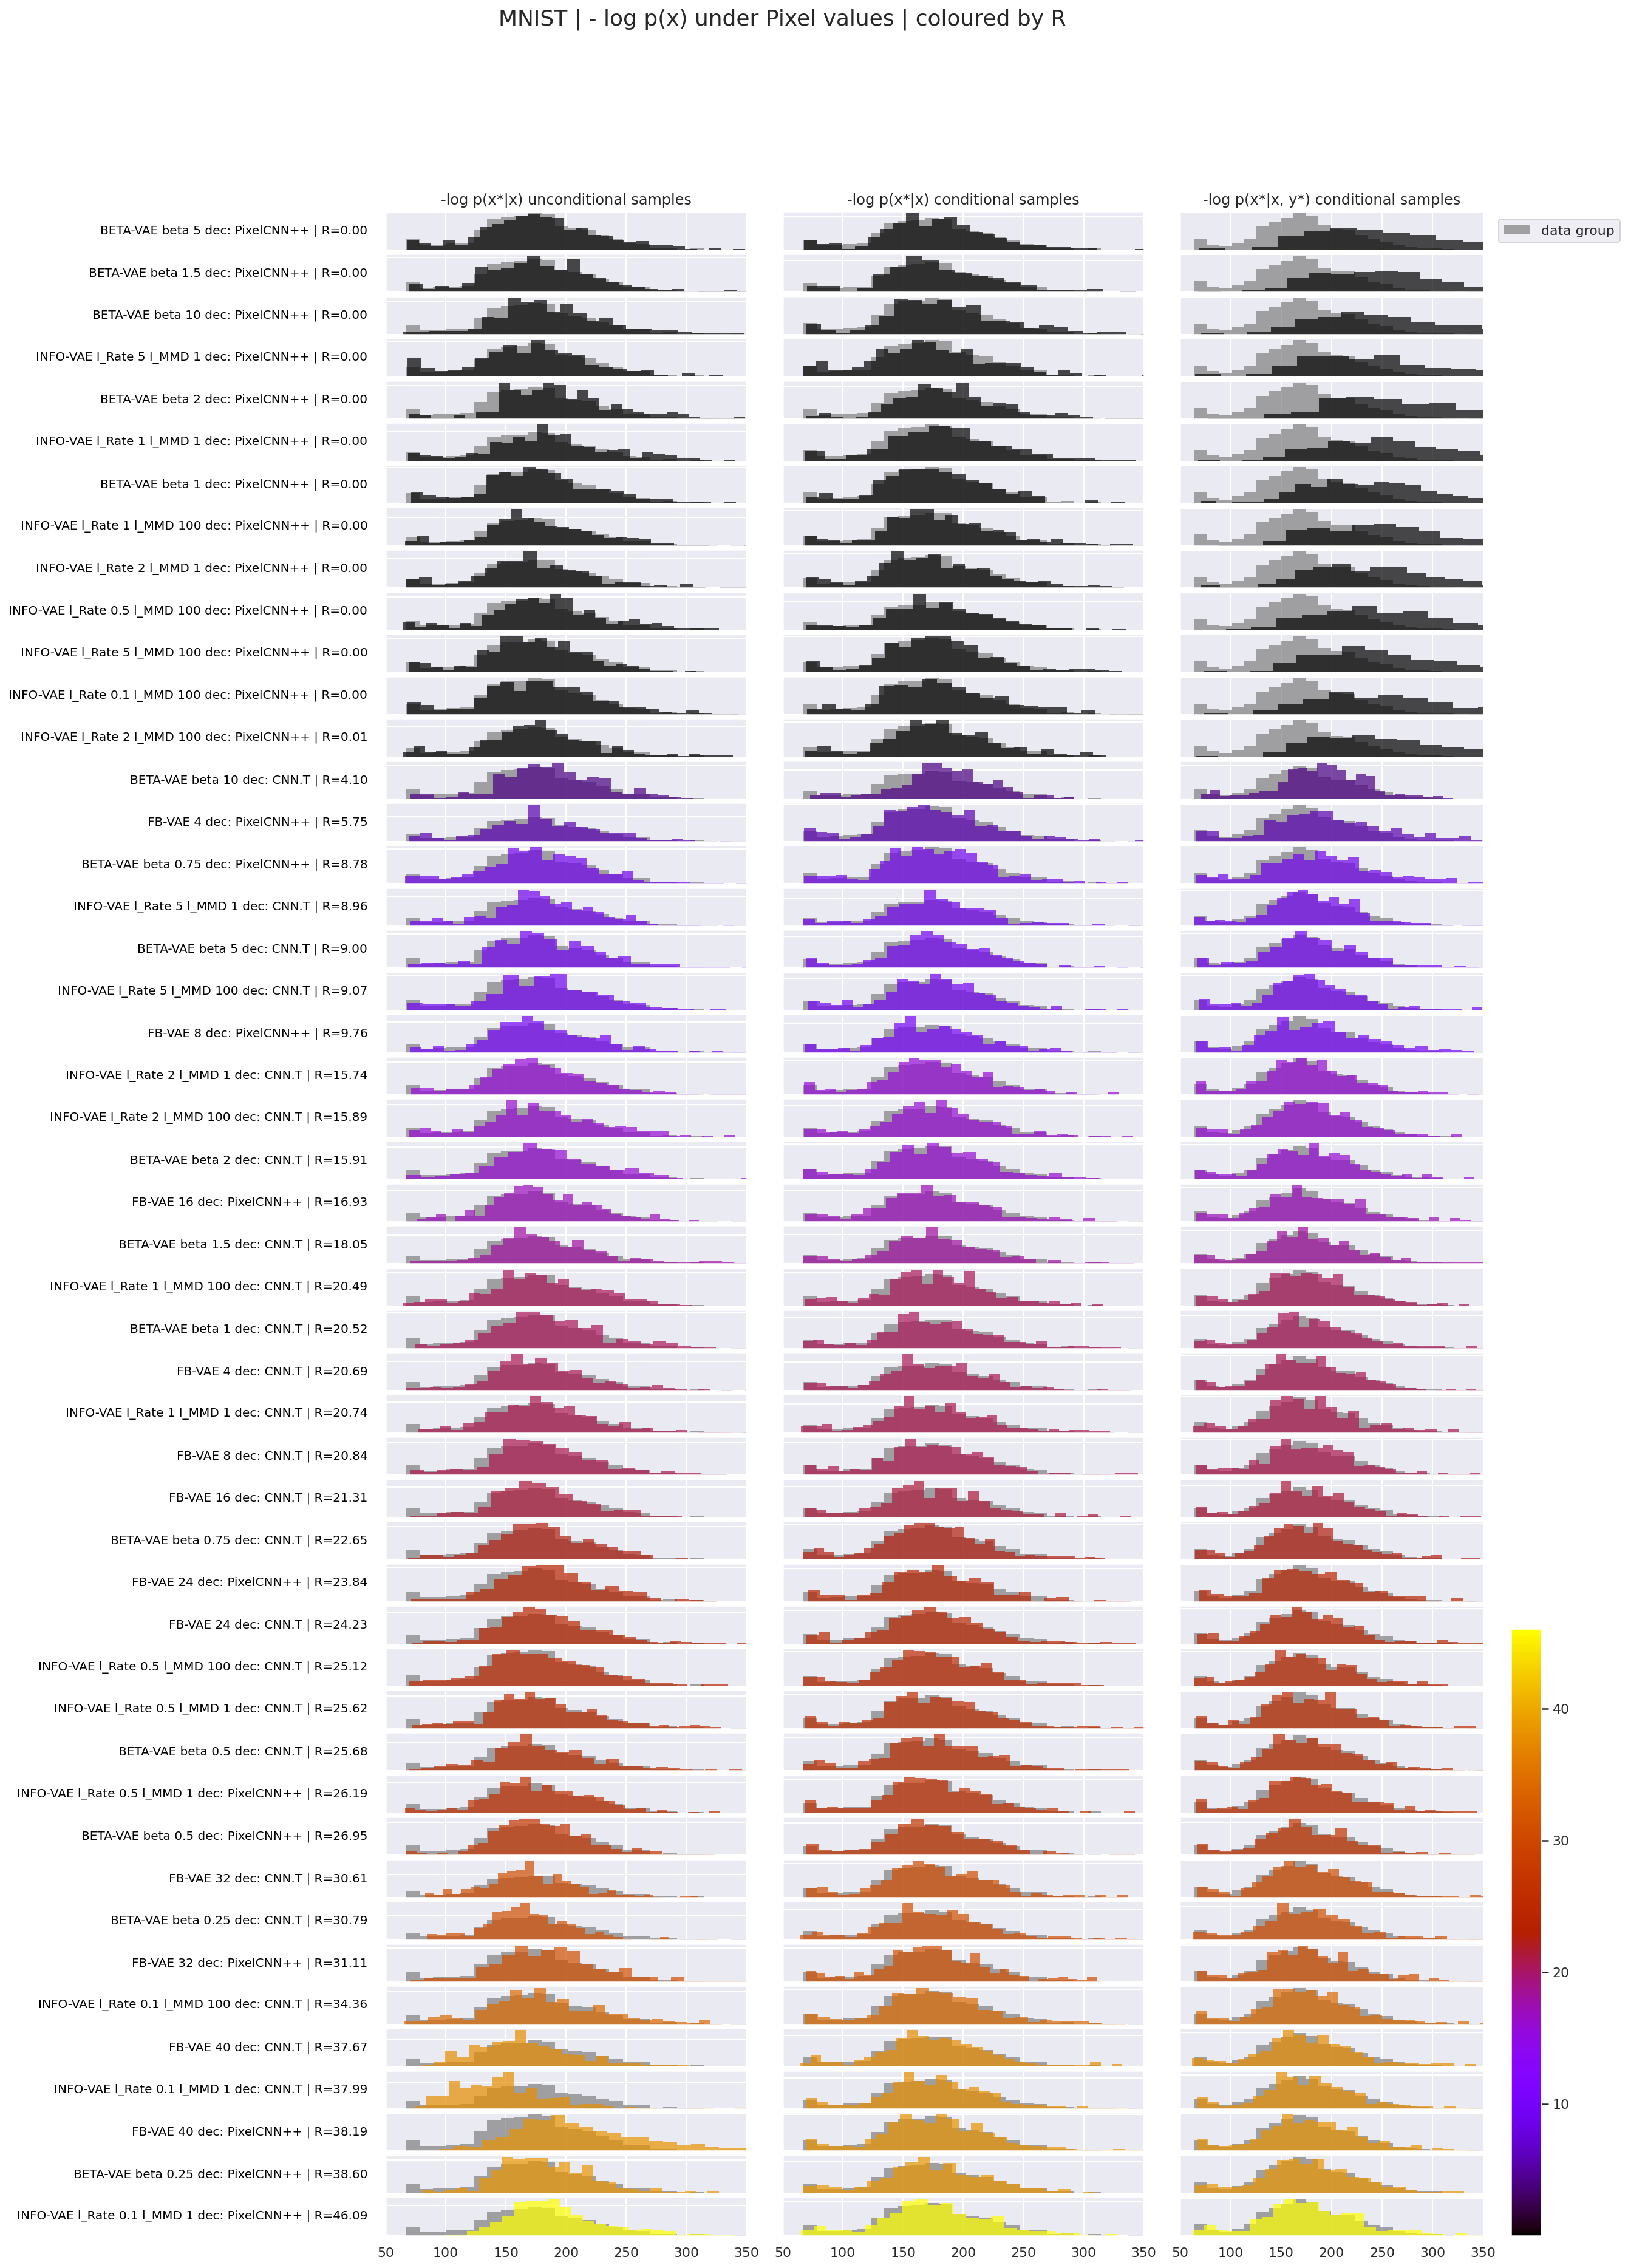

In [27]:
xlims = [[50, 350], [50, 350], [50, 350]]
ylims = [None, None, None]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="MNIST",
                                         latent_structure="Pixel values",
                                         sort_name="R", 
                                         bins=30,
                                         cm_shrink=0.3,
                                         cm_name="gnuplot",
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None,
                                         sort_ascend=True, 
                                         row_height=0.5)

Rows: 48, cols: 3, every: 1, n_groups: 48


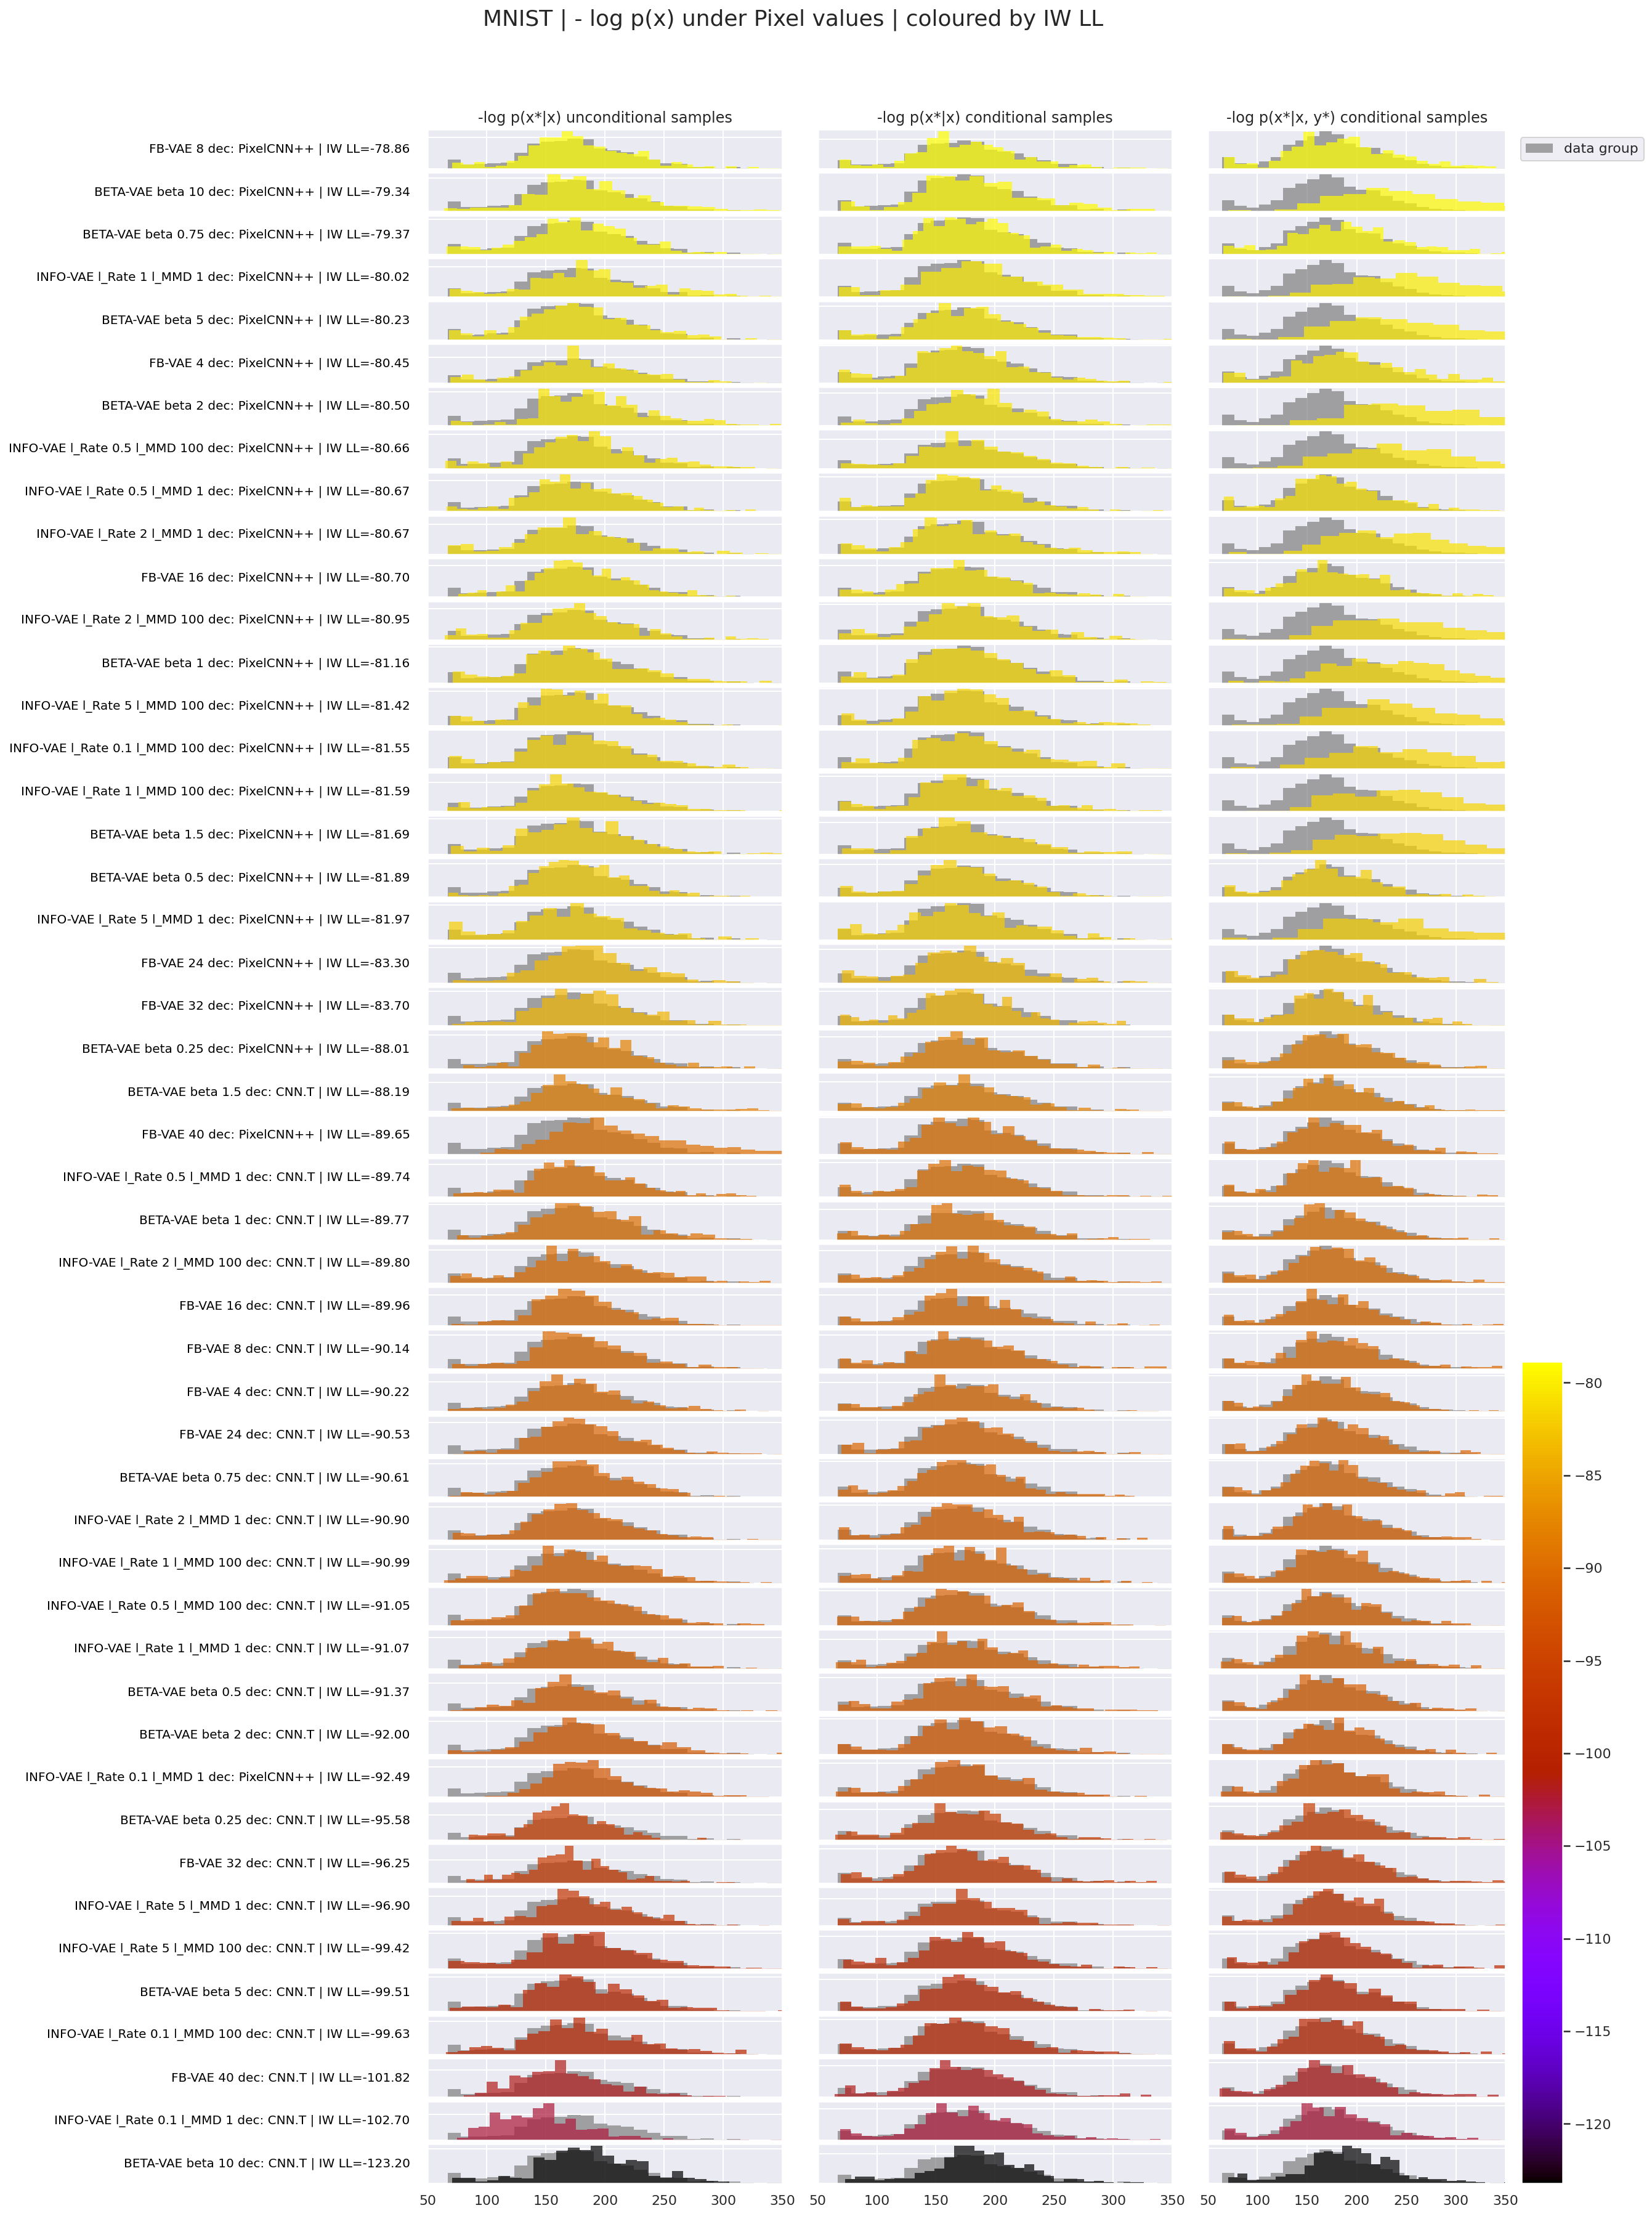

In [28]:
xlims = [[50, 350], [50, 350], [50, 350]]
ylims = [None, None, None]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="IW LL", 
                                         dataset_name="MNIST",
                                         latent_structure="Pixel values",
                                         sort_name="IW LL", 
                                         bins=30,
                                         cm_shrink=0.4,
                                         cm_name="gnuplot",
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None,
                                         sort_ascend=False, 
                                         row_height=0.5)

# Analyse surprisal distribution with a DP mixture of truncated normals

STAT: unconditional_unconditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 180.80988 std y: 47.292107 min_y: 63.977966 max y: 430.22147


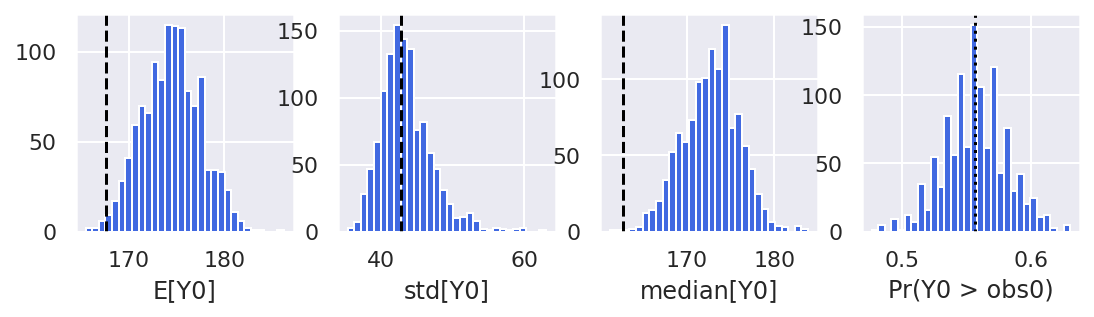

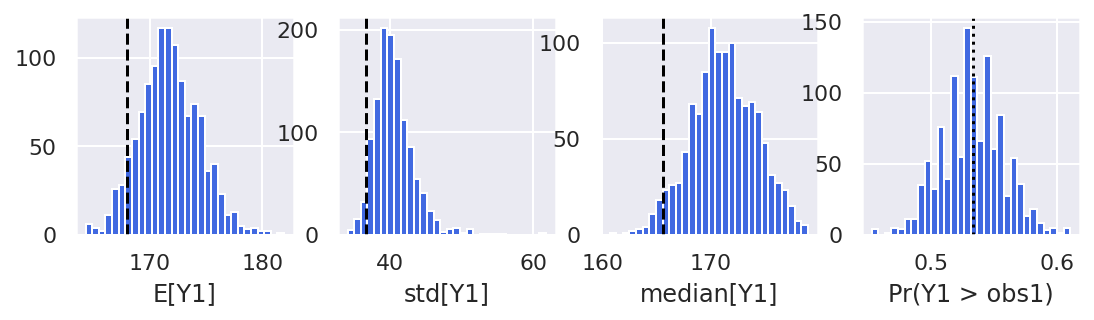

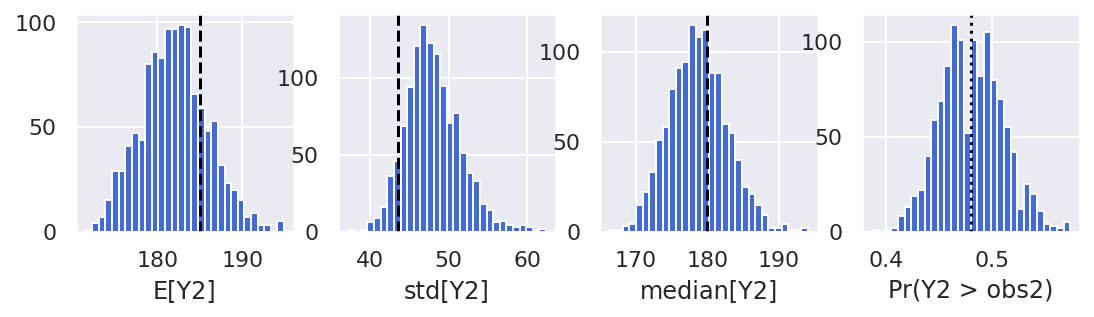

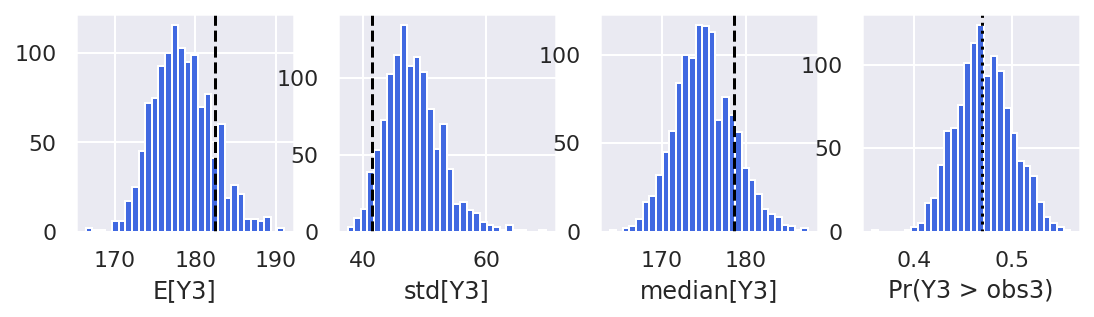

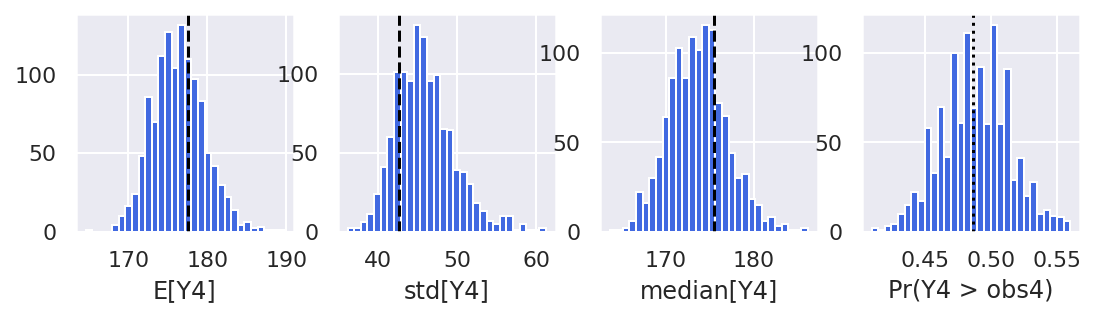

mean y: 180.80988 std y: 47.292107 min_y: 63.977966 max y: 430.22147


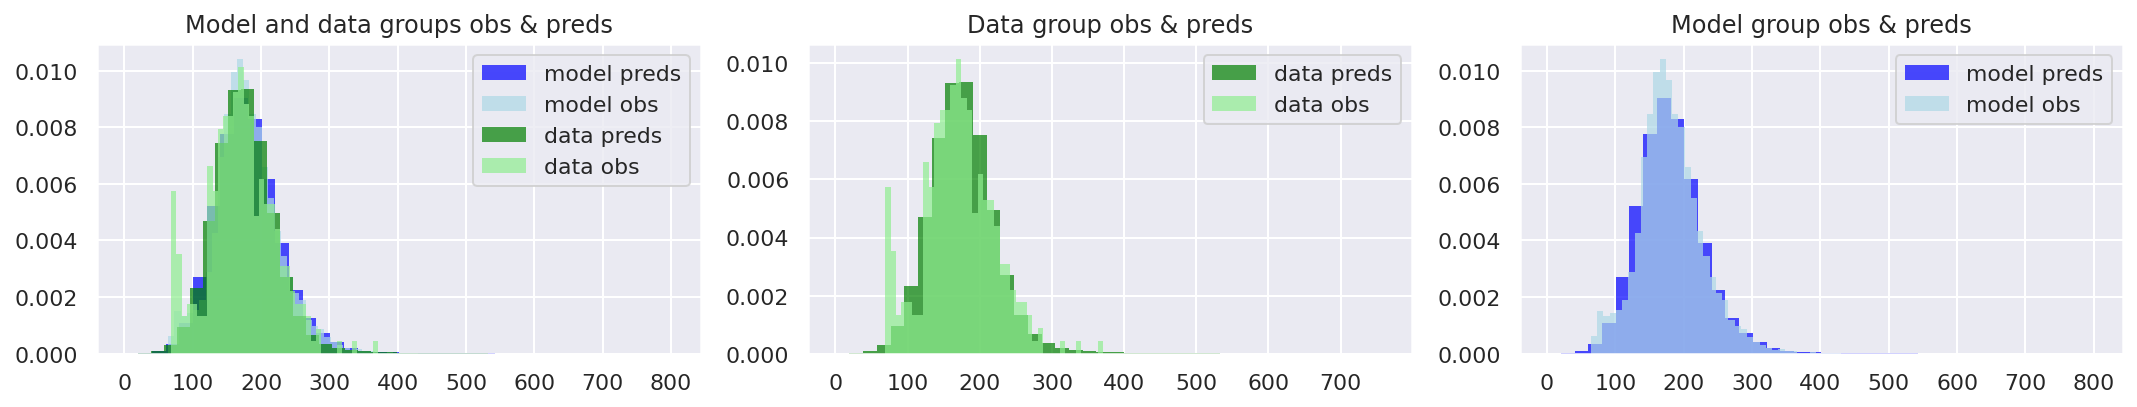

mean y: 180.80988 std y: 47.292107 min_y: 63.977966 max y: 430.22147


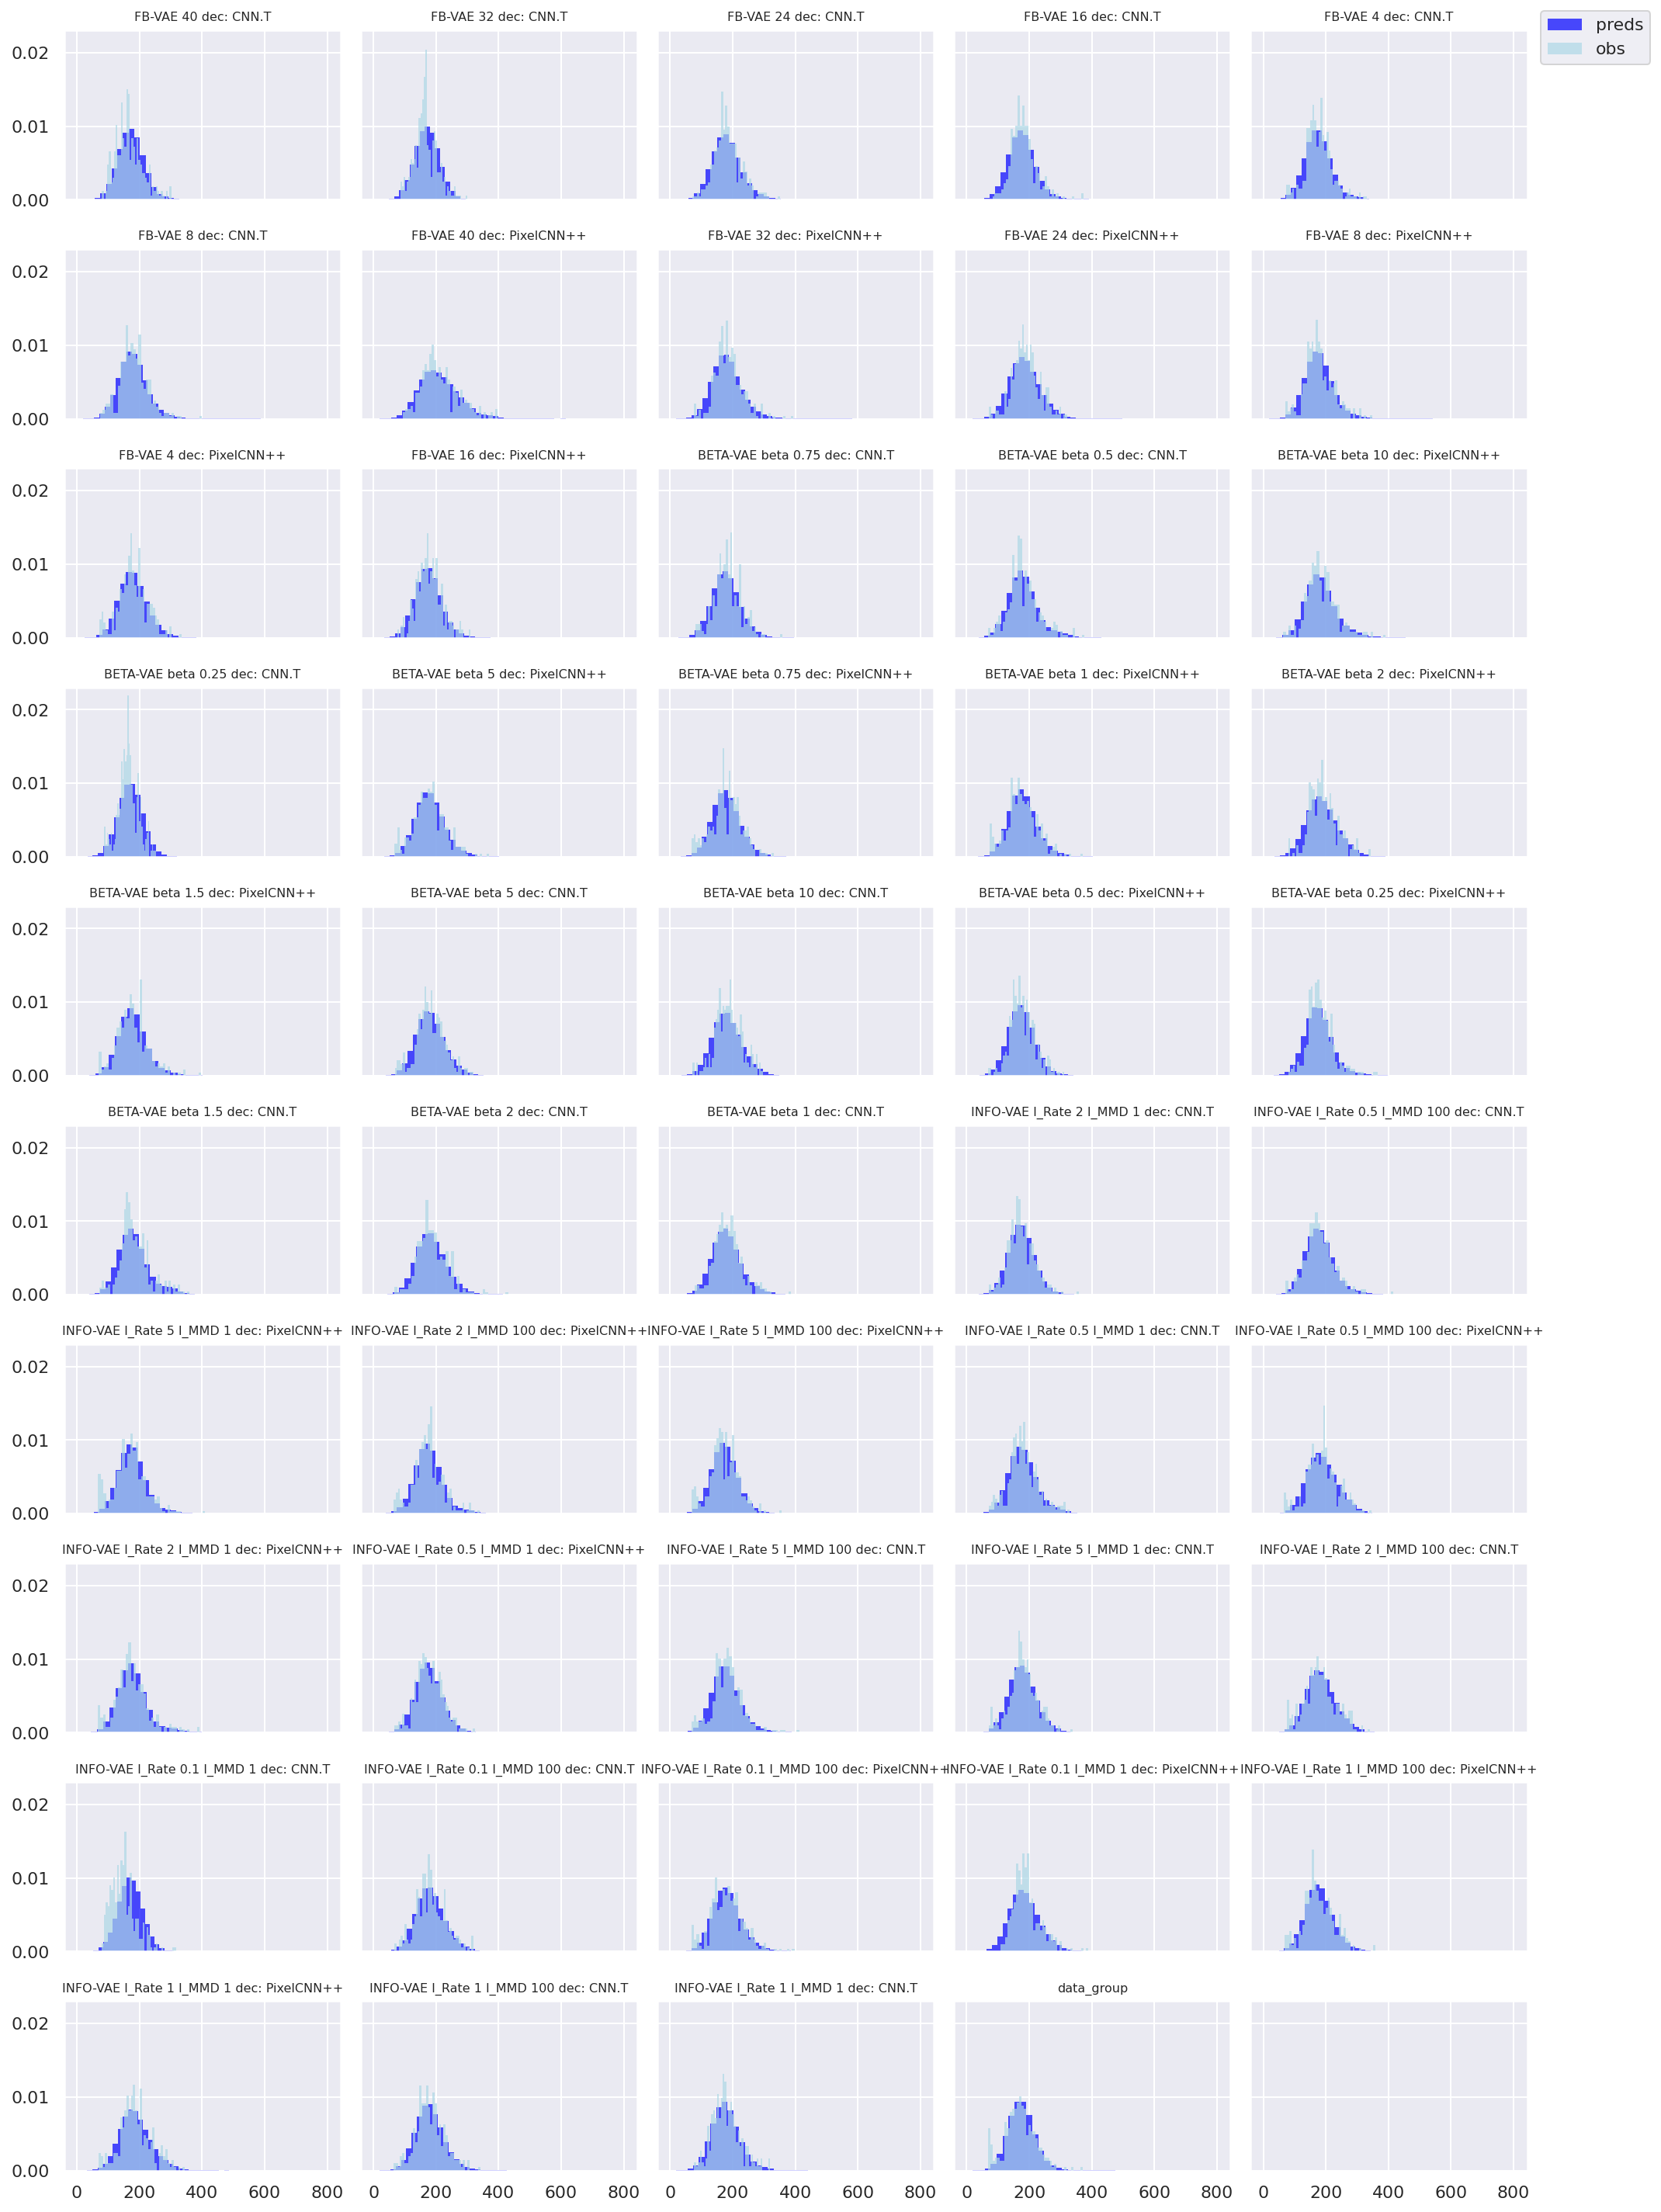

----------------------------------------
STAT: unconditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 176.21594 std y: 48.05971 min_y: 64.09842 max y: 401.3998


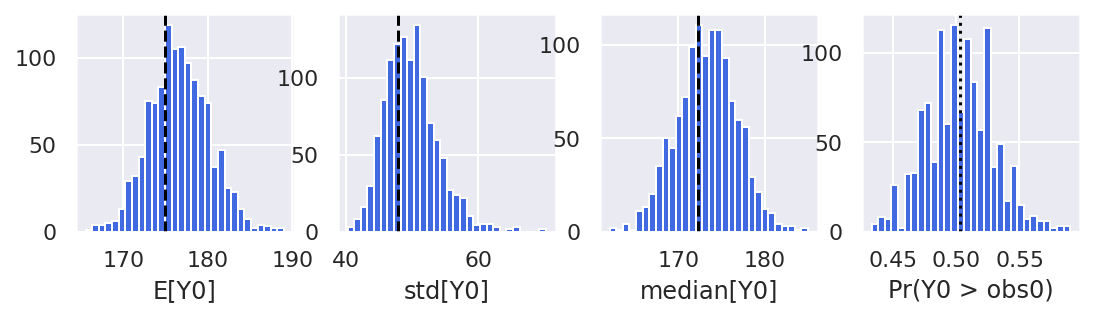

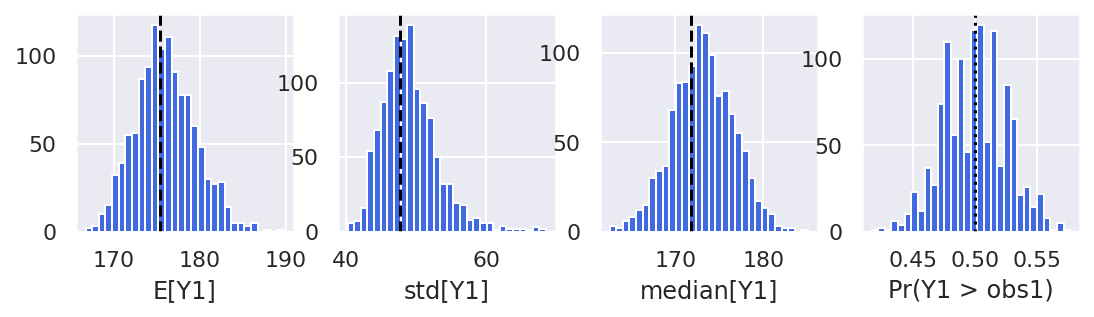

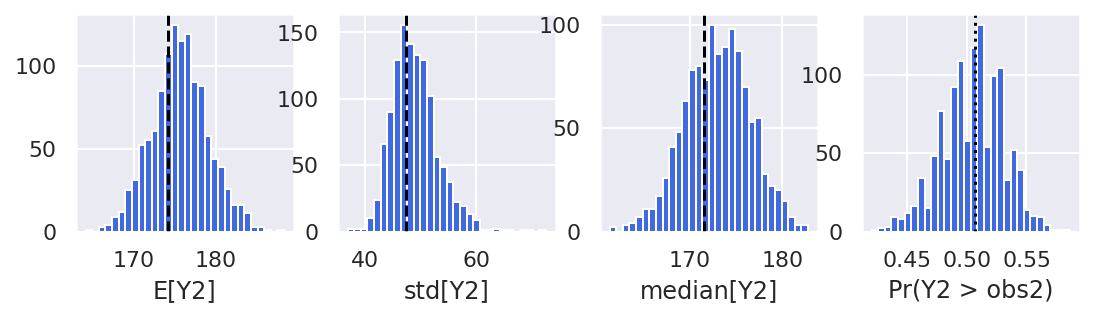

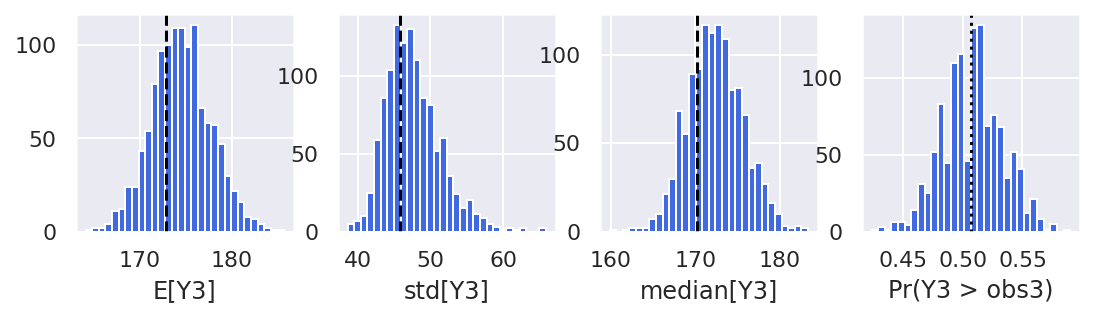

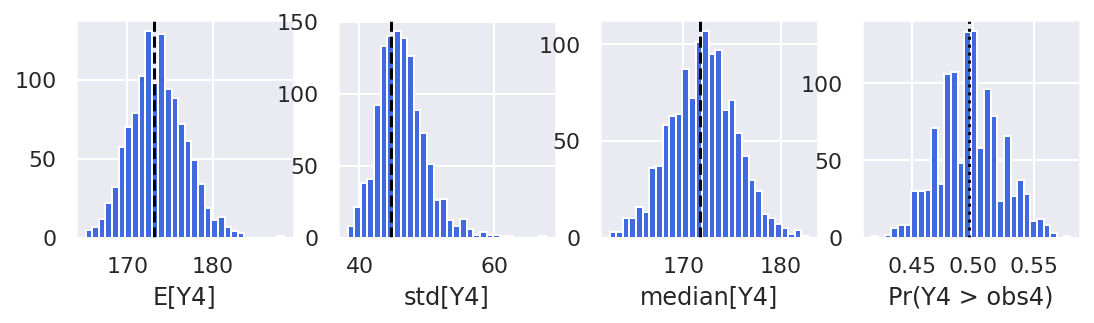

mean y: 176.21594 std y: 48.05971 min_y: 64.09842 max y: 401.3998


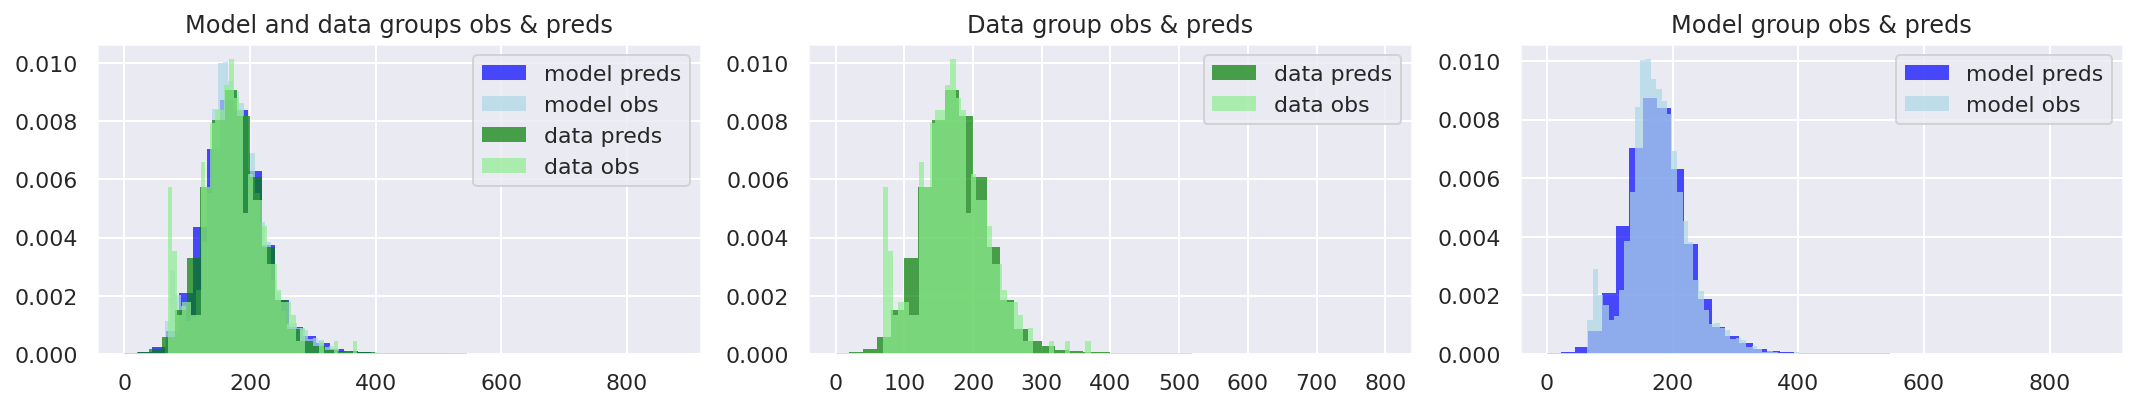

mean y: 176.21594 std y: 48.05971 min_y: 64.09842 max y: 401.3998


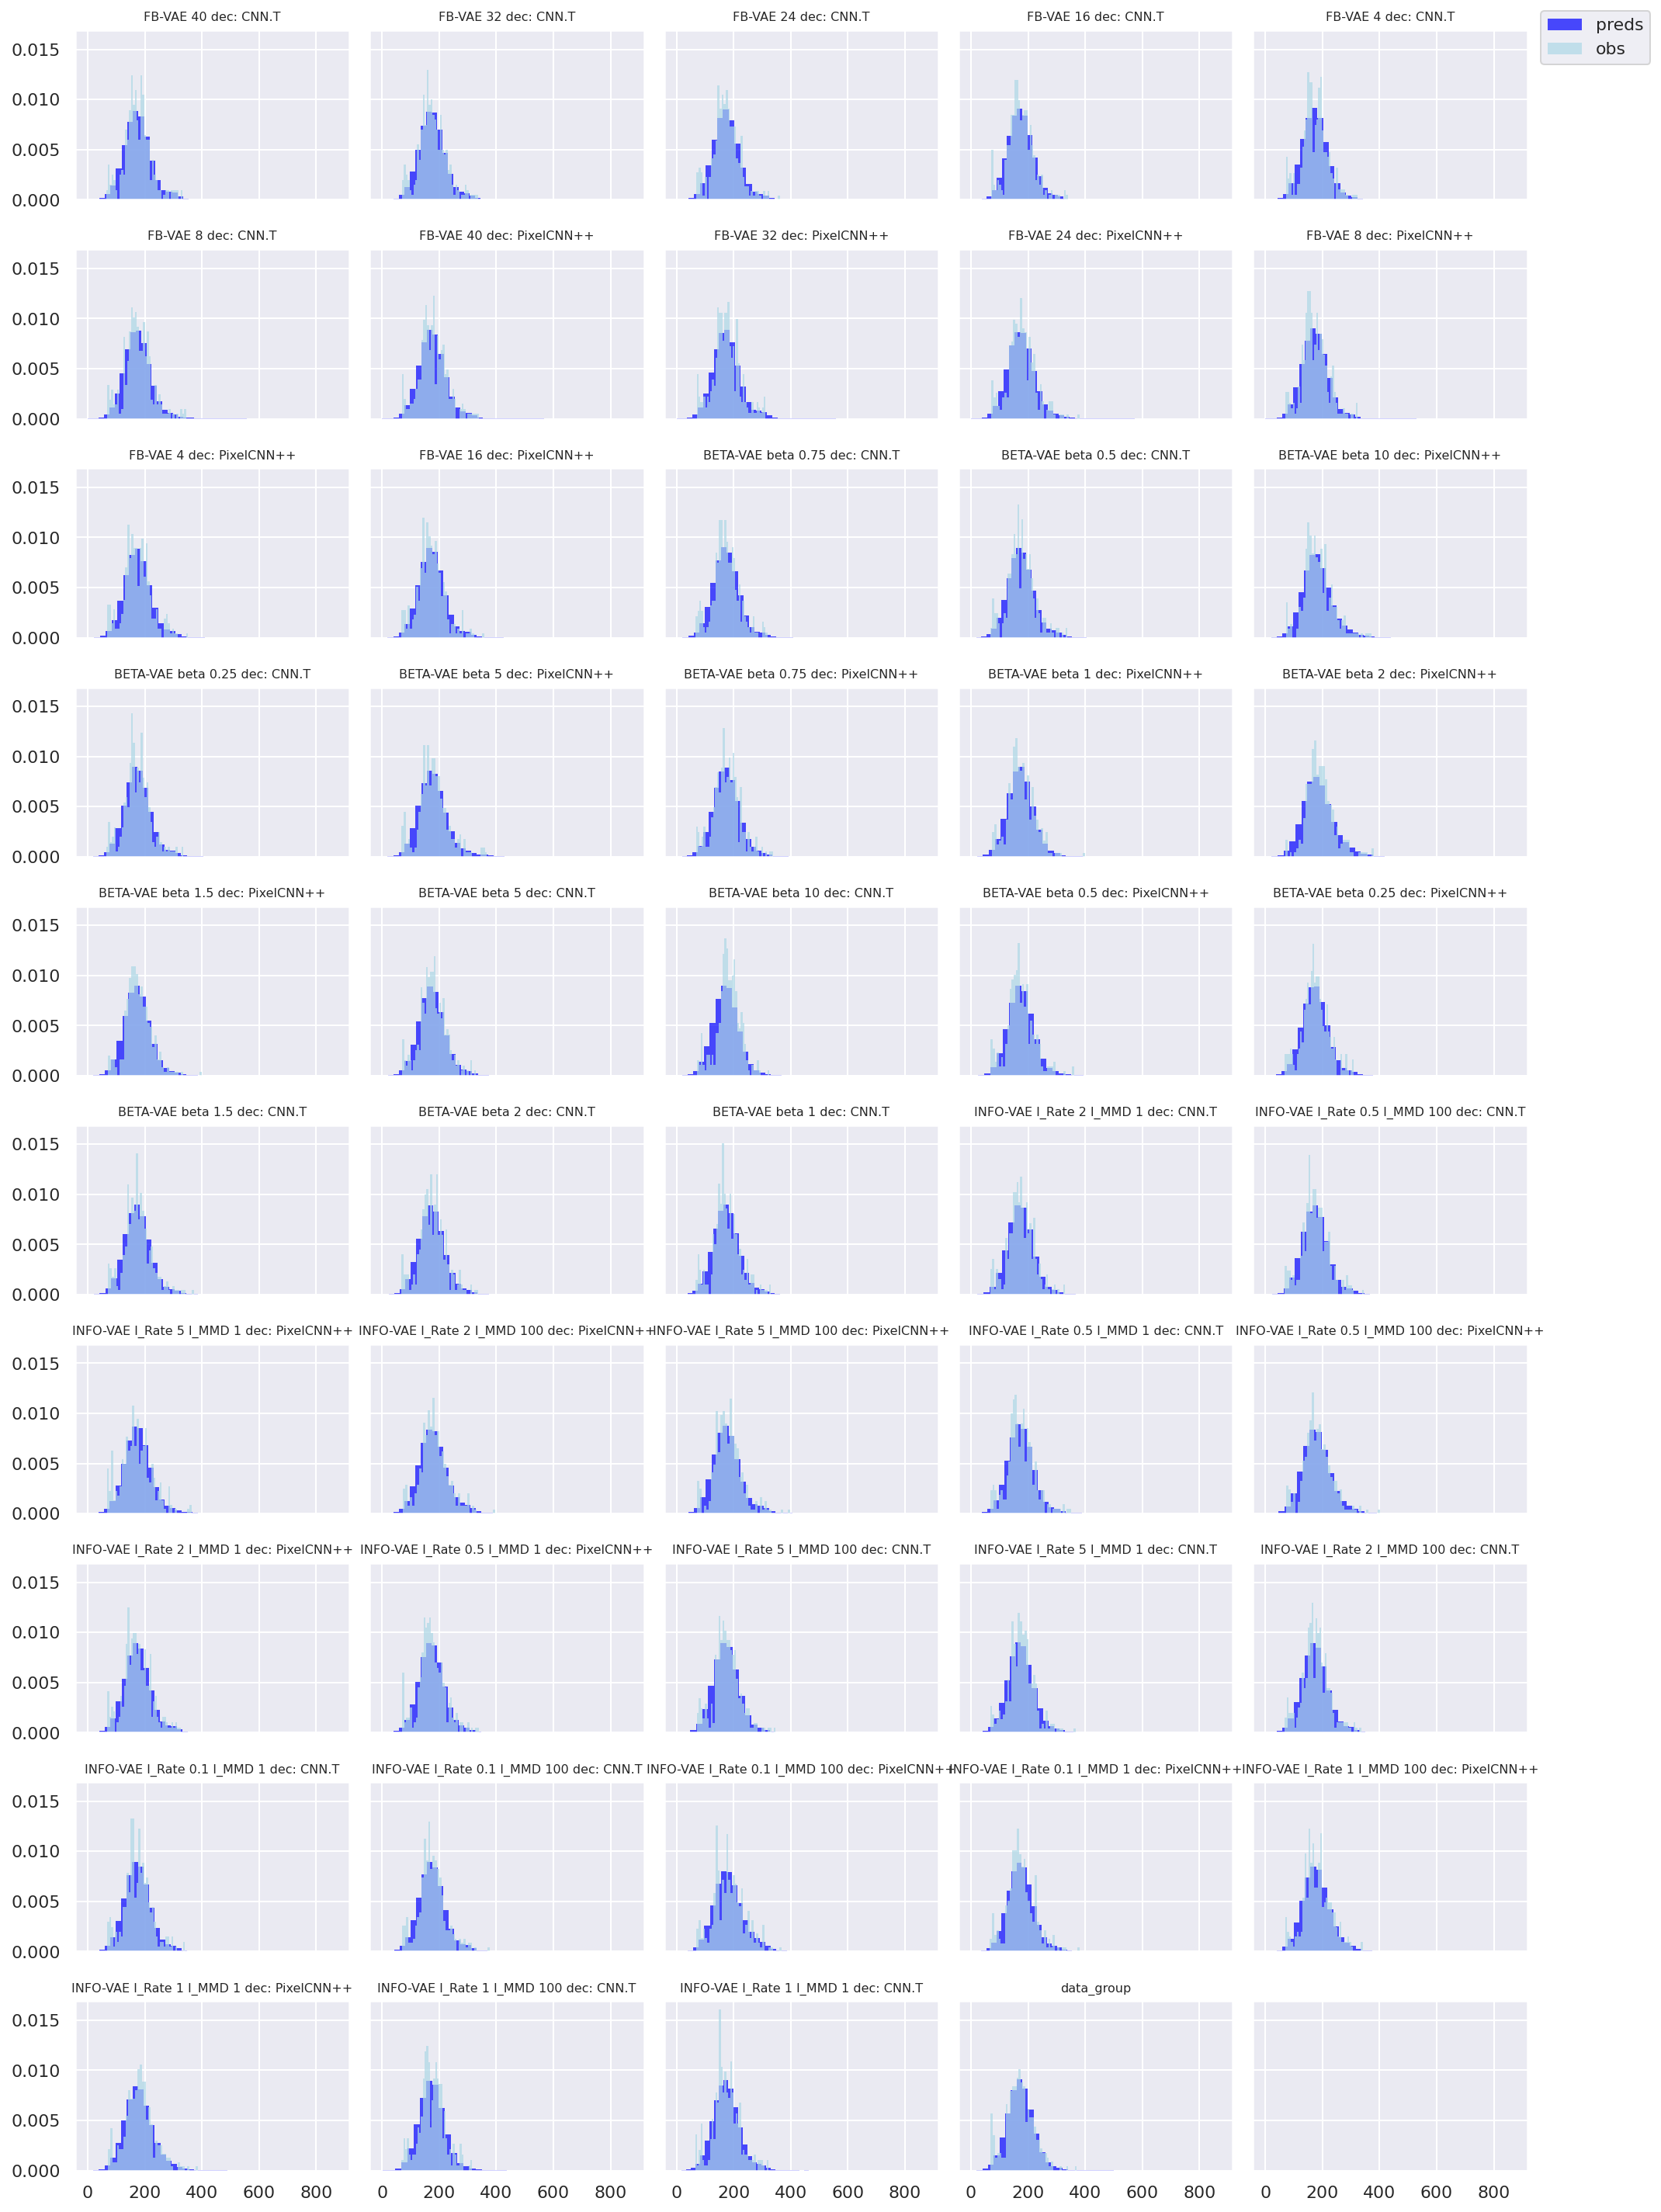

----------------------------------------
STAT: conditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 201.04247 std y: 75.53056 min_y: 61.795834 max y: 895.80646
Warning, values higher than 1000.0, filtering those out.


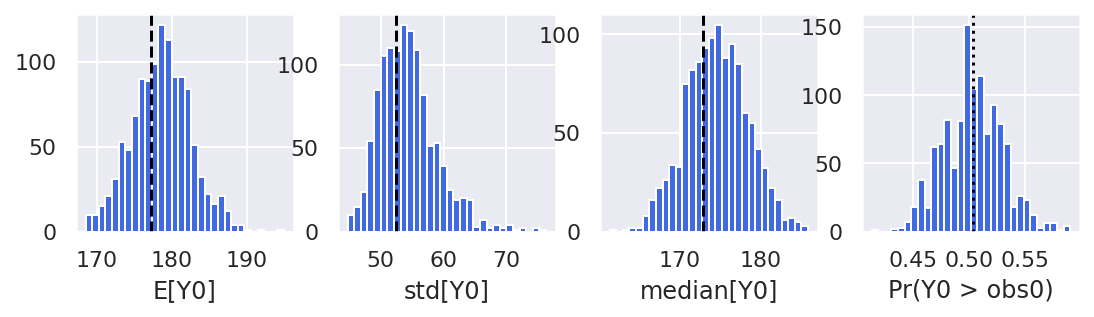

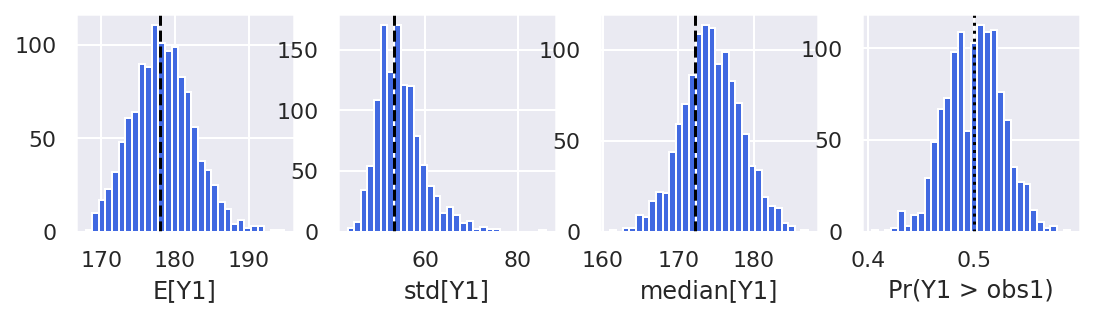

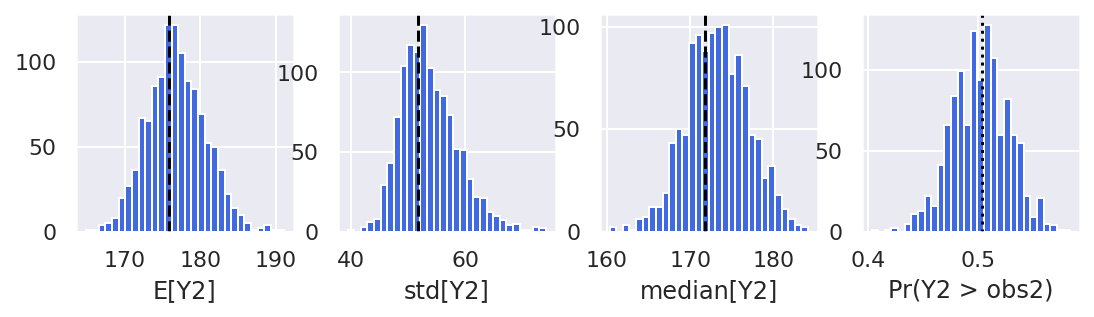

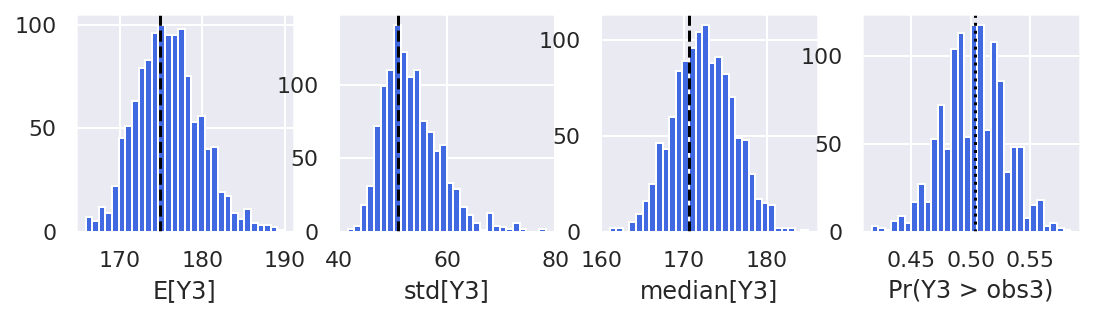

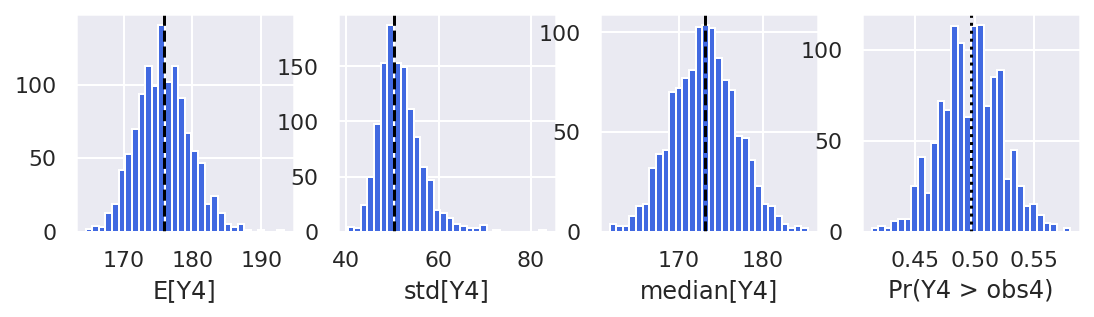

mean y: 201.04247 std y: 75.53056 min_y: 61.795834 max y: 895.80646
Warning, values higher than 1000.0, filtering those out.


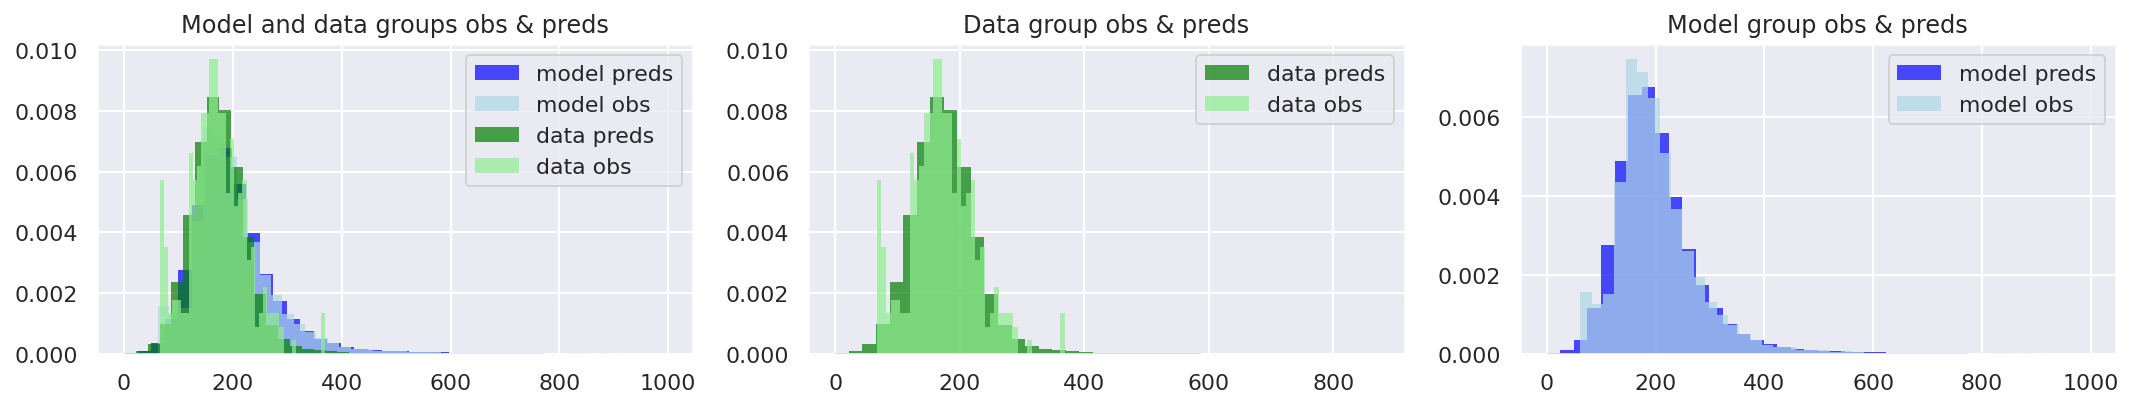

mean y: 201.04247 std y: 75.53056 min_y: 61.795834 max y: 895.80646
Warning, values higher than 1000.0, filtering those out


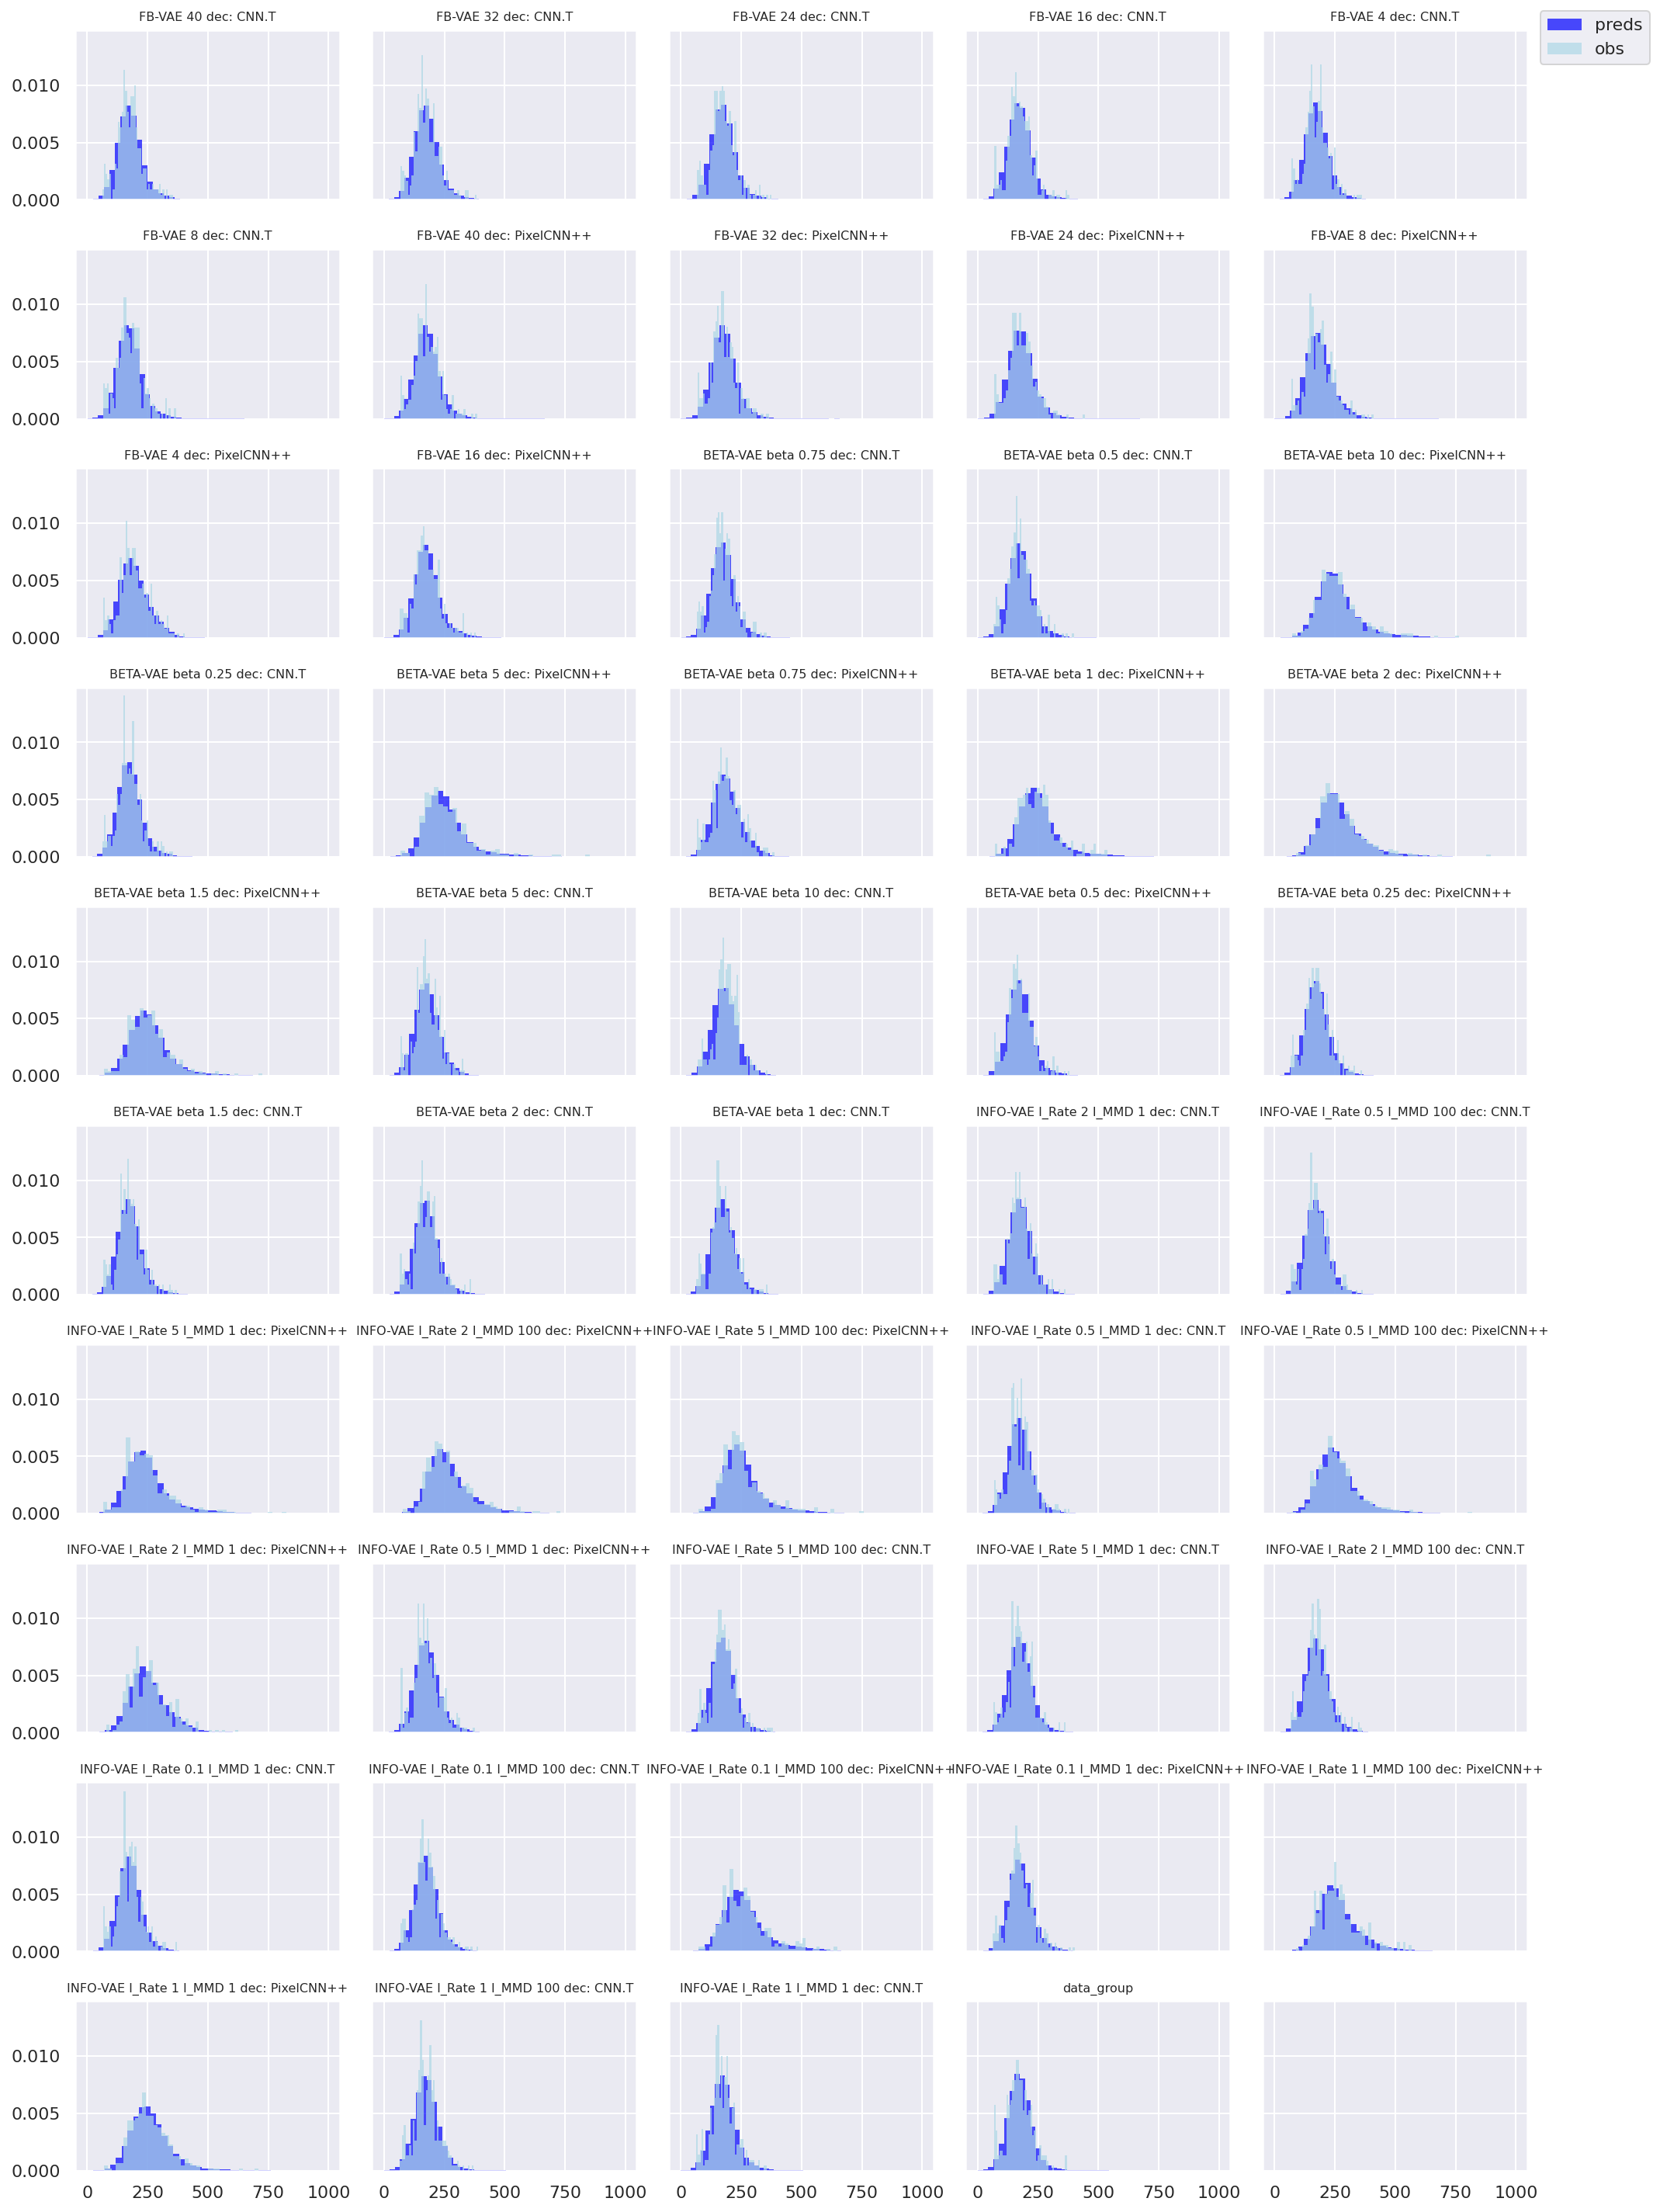

----------------------------------------


In [17]:
perform_prior_predictive_checks = True
perform_posterior_predictive_checks = True

MAX_SAMPLES_PER_GROUP = 300

NUM_COMPS = 5
NUM_CHAINS = 1
NUM_WARMUP = 100
NUM_SAMPLES = 1200

DP_ALPHA = 1.0
OBS_DIST = "truncated_normal"
TRUNCATED_LOW = 0.0

MAX_GROUPS = 100 # all
MAX_PLOT_CHECK = 5

if FIT_SURPRISAL_DPS:
    dp_mixtures = dict()
    #dp_mixtures = pickle.load(open(SAVE_SURPRISAL_DP_FILE, "rb"))
    
    stats = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
    for stat_name in stats:
        print(stat_name)
        
        if stat_name in dp_mixtures:
            print("Did this one already, continuing..")
            continue

        group_names = []
        observations = []
        
        c = 0
        for i, (k, v) in enumerate(surprisal_values.items()):
            group_names.append(k)
            observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))

            c += 1
            if c == MAX_GROUPS:
                break
                
        if "data_group" not in group_names:
            group_names.append("data_group")
            observations.append(np.array(surprisal_values["data_group"][stat_name][:MAX_SAMPLES_PER_GROUP]))
            
        print("Number of groups", len(observations))

        dp_mixture = DPMixture(
            group_names, 
            observations, 
            obs_dist=OBS_DIST,
            truncated_normal_low=TRUNCATED_LOW,
            DP_alpha=DP_ALPHA, 
            num_comps=NUM_COMPS, 
            num_samples=NUM_SAMPLES, 
            num_chains=NUM_CHAINS, 
            num_warmup=NUM_WARMUP
        )
    
        if perform_prior_predictive_checks:
            print("-"*40)
            print("PRIOR PREDICTIVE PLOTS")
            prior_samples = dp_mixture.draw_prior_predictions(num_samples=400)
            
            print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
            
            surprisal_dp_plot_checks(dp_mixture, prior_samples["y"], plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
                
            print("-"*40)
            
        dp_mixture.run()

        dp_mixtures[stat_name] = dp_mixture
        
        if perform_posterior_predictive_checks:
            print("-"*40)
            print("POSTERIOR PREDICTIVE PLOTS")
            
            posterior_samples = dp_mixture.draw_posterior_predictions()
            samples = posterior_samples["y"]
            
            surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)
            print("-"*40)
    
        pickle.dump(dp_mixtures, open(SAVE_SURPRISAL_DP_FILE, "wb"))
    
else:
    if os.path.exists(SAVE_SURPRISAL_DP_FILE):
        dp_mixtures = pickle.load(open(SAVE_SURPRISAL_DP_FILE, "rb"))
        
        for stat_name, dp_mixture in dp_mixtures.items():
            print("STAT:", stat_name)
            if perform_posterior_predictive_checks:
                print("-"*40)
                print("POSTERIOR PREDICTIVE PLOTS")

                posterior_samples = dp_mixture.draw_posterior_predictions()
                samples = posterior_samples["y"]

                surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
                plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
                plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)
                print("-"*40)
    else:
        print(f"No DPs saved in SAVE_SURPRISAL_DP_FILE={SAVE_SURPRISAL_DP_FILE}, set FIT_SURPRISAL_DPS=True to re-run.")

# Make surprisal plot with DP predicted surprisal values

mean y: 180.80988 std y: 47.292107 max y: 430.22147 min_y 63.977966
CUMSUM SORT
mean y: 176.21594 std y: 48.05971 max y: 401.3998 min_y 64.09842
CUMSUM SORT
mean y: 201.04247 std y: 75.53056 max y: 895.80646 min_y 61.795834
CUMSUM SORT
Leaving out autoencoder run with high R.
Rows: 48, cols: 3, every: 1, n_groups: 48


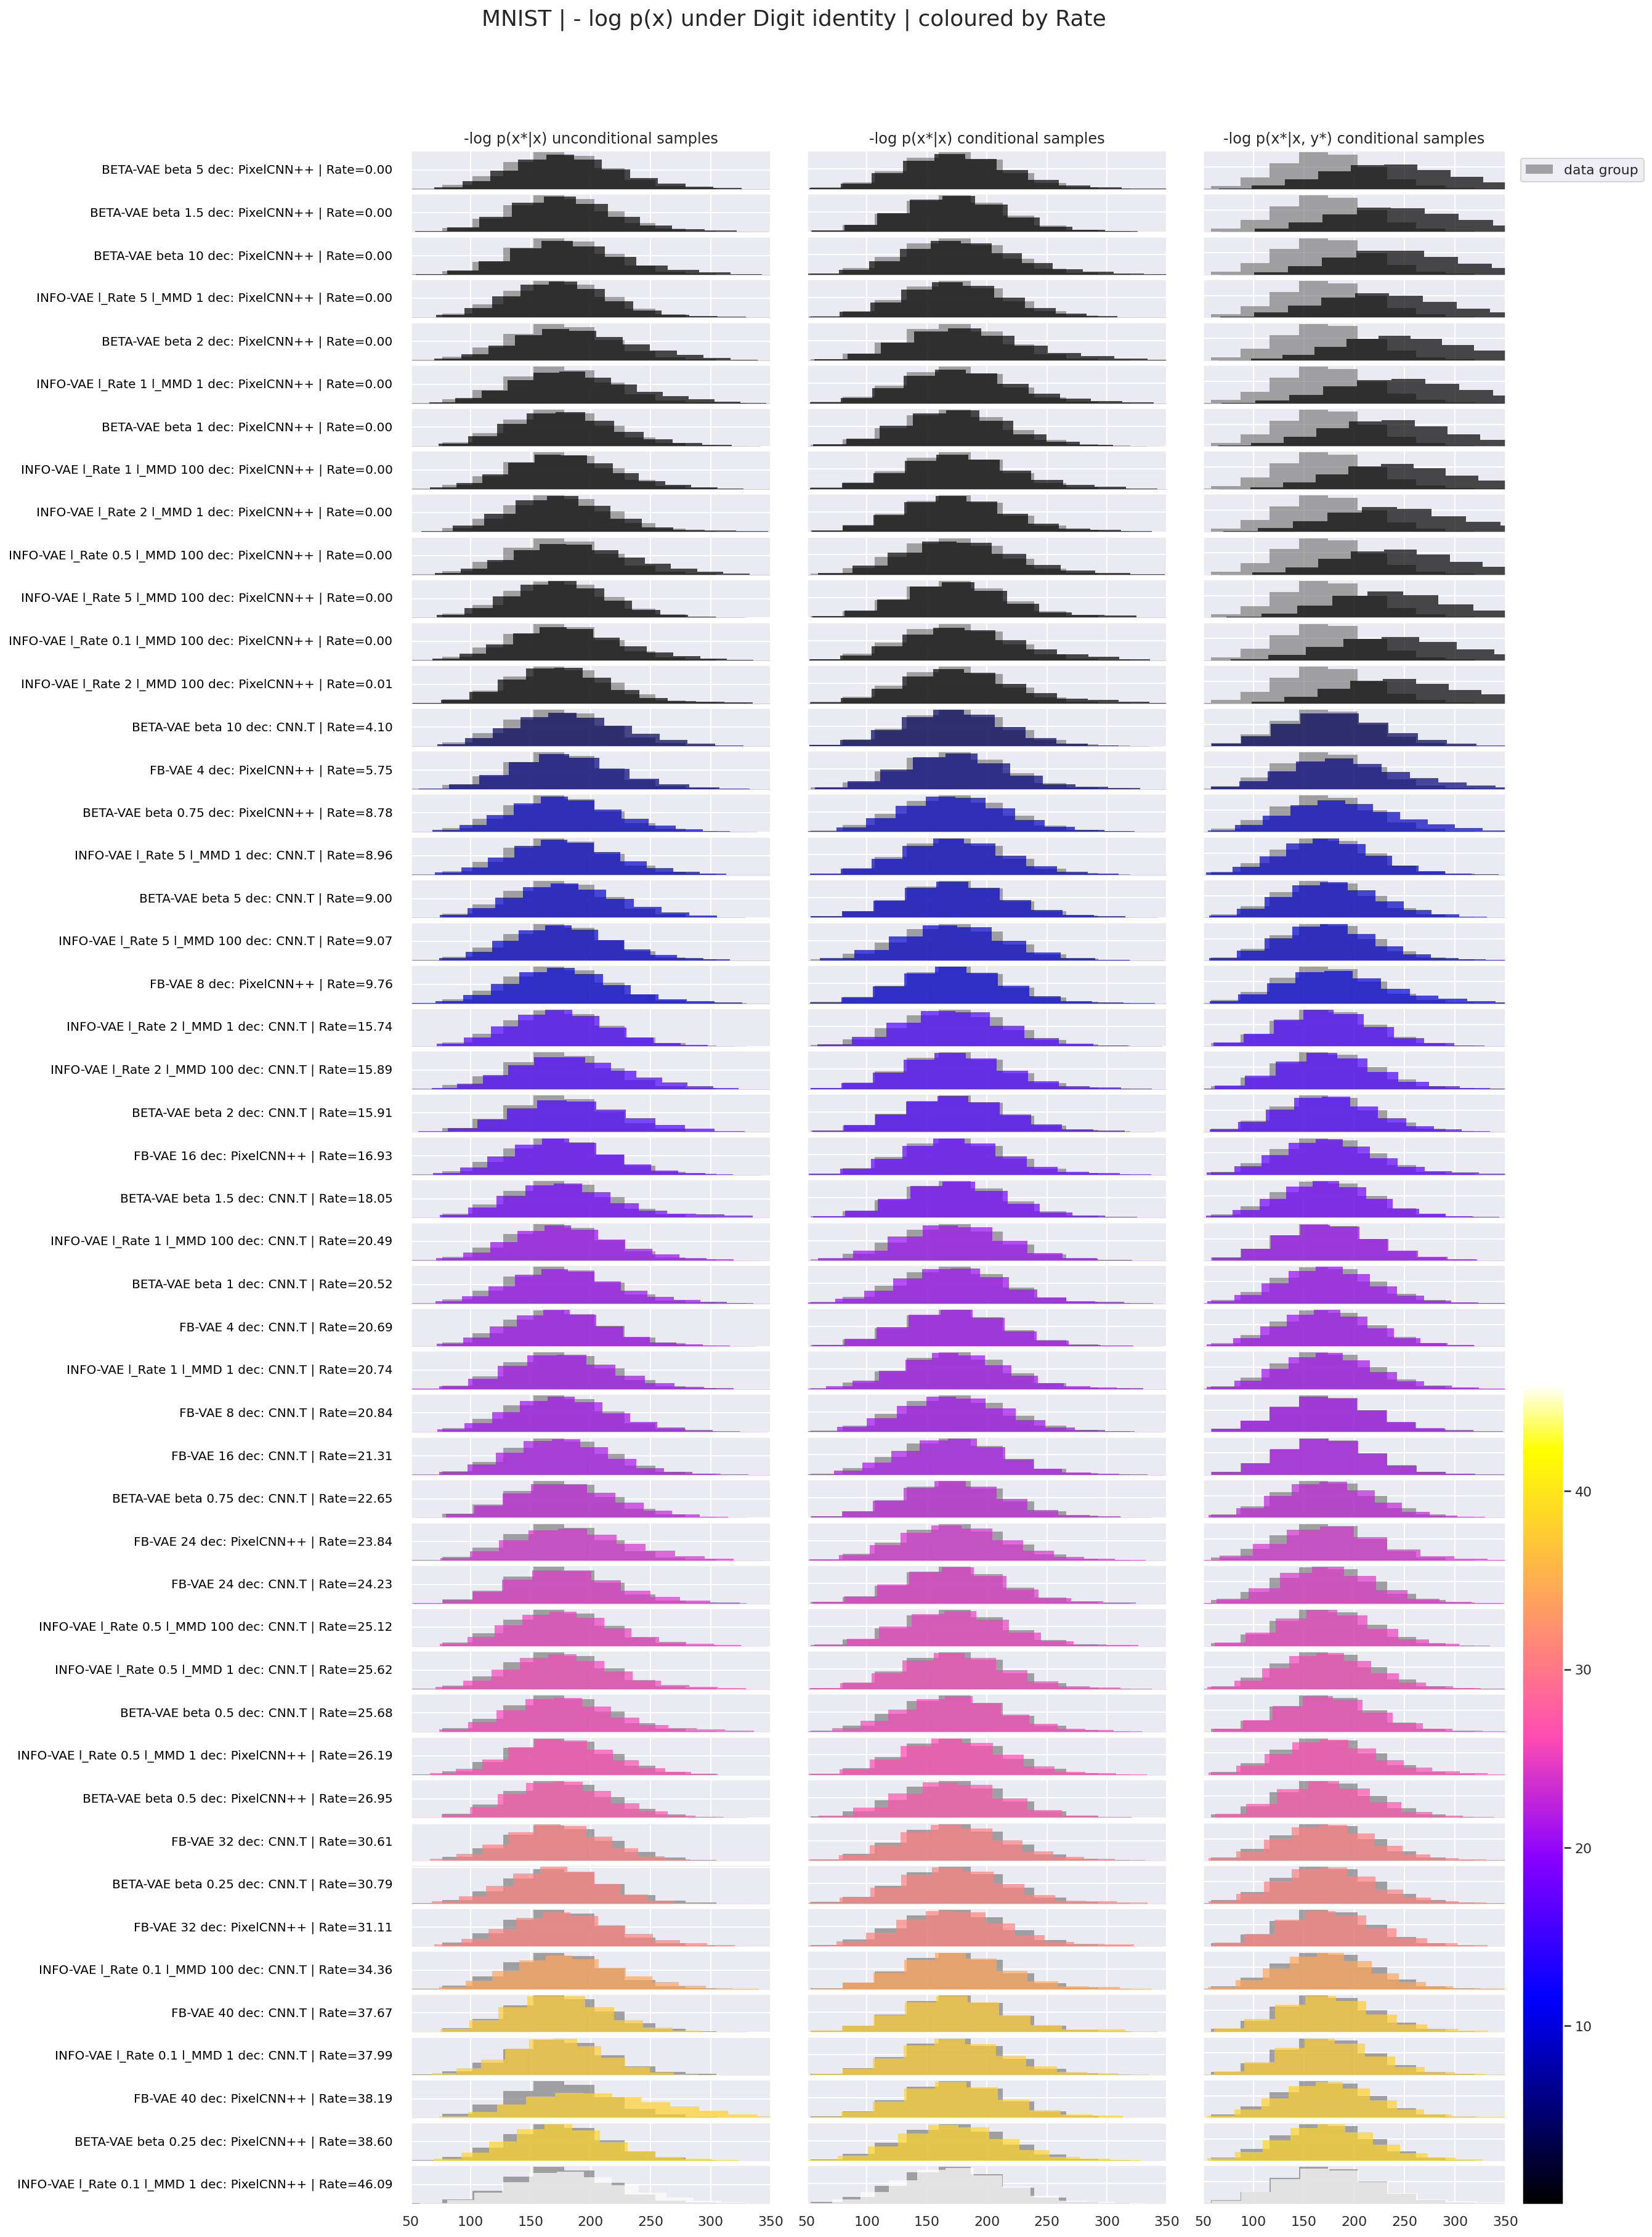

In [32]:
res_dict = dict()

for stat_name, dp_mixture in dp_mixtures.items():
    
    # [N_s, N_x_all]
    post_y = np.array(dp_mixture.draw_posterior_predictions()["y"])
    
    for group_idx, group_name in enumerate(dp_mixture.group_names):
        
        if group_name not in res_dict:
            res_dict[group_name] = dict()
        
        post_y_g = post_y[:, dp_mixture.obs_g == group_idx].flatten()
        
        res_dict[group_name][stat_name] = post_y_g
        
xlims = [[50, 350], [50, 350], [50, 350]]
# xlims = [None, None, None]

# xlims = [[0, 500], [0, 500], [0, 500]]
ylims = [None, None, None]

global_stats_df_filter = global_stats_df[global_stats_df["kl_prior_post"] < 70]
print("Leaving out autoencoder run with high R.")

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=res_dict, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="MNIST",
                                         latent_structure="Digit identity",
                                         sort_name="Rate", 
                                         cm_shrink=0.4,
                                         cm_name="gnuplot2",
                                         bins=30,
                                         title_size=18,
                                         title_y=1.05,
                                         subsample_nrows=None, 
                                         sort_ascend=True, 
                                         row_height=0.5)

# Now assess "divergence" from model sample surprisal values from data group in three ways:

1. KL between component assignments under the DP Mixture
2. Difference between estimated densities under the DP Mixture
3. Wasserstein distance between surprisal value histograms (no DP Mixture used)

In [33]:


def kl_component_dist_and_data_group_distance(self):
    # [N_s, N_g, N_c]
    omega = self.posterior_samples["omega"]
    data_group_id = self.group_names.index("data_group")
    omega_data_group = omega[:, data_group_id, :]

    omega_tensor = torch.FloatTensor(np.array(omega))
    omega_data_group_tensor = torch.FloatTensor(np.array(omega_data_group)).unsqueeze(1)

    omega_dists = td.Categorical(probs=omega_tensor)
    omega_data_group_dists = td.Categorical(probs=omega_data_group_tensor)

    # [N_s, N_g, N_c] -> [N_s, N_g] -> [N_g]
    kl = td.kl_divergence(omega_data_group_dists, omega_dists)
    kl_all = kl.permute(1, 0) # [N_g, N_s]
    
    kl_avg = kl.mean(axis=0)  # avg sample dim: [N_s, N_g] -> [N_g]

    kl_comps_data_group_avg = dict()
    kl_comps_data_group_dists = dict()
    
    for group_idx, group_name in enumerate(self.group_names):
        
        kl_comps_data_group_avg[group_name] = kl_avg[group_idx].item()
        kl_comps_data_group_dists[group_name] = kl_all[group_idx, :].numpy()

    return kl_comps_data_group_avg, kl_comps_data_group_dists

def compute_all_divergences_data_model_groups(dp_mixtures, surprisal_values, num_components=3):
    from scipy import stats
    
    kl_component_assignments_all_dps = dict()
    
    kl_comp_dists = {}

    for stat, dp_mixture in dp_mixtures.items():
        # two dicts
        kl_comps_data_group_avg, kl_comps_data_group_dists = kl_component_dist_and_data_group_distance(dp_mixture)
        kl_component_assignments_all_dps["kl_comp " + stat] = kl_comps_data_group_avg
        kl_comp_dists[stat] = kl_comps_data_group_dists

    kl_component_assignments_all_dps_df = pd.DataFrame(kl_component_assignments_all_dps)
    kl_component_assignments_all_dps_df["kl_comp sum"] = kl_component_assignments_all_dps_df.sum(axis=1)

    kl_densities_all_dps = dict()
    for stat, dp_mixture in dp_mixtures.items():
        kl_density_est = estimate_kl_densities_dp_mixture(dp_mixture, num_components=num_components)
        kl_densities_all_dps["kl_dens " + stat] = kl_density_est

    kl_densities_all_dps_df = pd.DataFrame(kl_densities_all_dps)
    kl_densities_all_dps_df["kl_dens sum"] = kl_densities_all_dps_df.sum(axis=1)

    wass_dists = dict()

    for k, v in surprisal_values.items():
        if k is not "data_group":
            wass_dists[k] = dict()
            for stat_name, stat in v.items():
                w = stats.wasserstein_distance(stat, surprisal_values["data_group"][stat_name])
                wass_dists[k]["wasserstein " + stat_name] = w

    wasserstein_df = pd.DataFrame(wass_dists).transpose()
    wasserstein_df["wasserstein sum"] = wasserstein_df.sum(axis=1)

    all_df = wasserstein_df.join(kl_component_assignments_all_dps_df).join(kl_densities_all_dps_df)

    return all_df, kl_comp_dists

In [21]:
all_df, kl_comp_dists = compute_all_divergences_data_model_groups(dp_mixtures, 
                                                                  surprisal_values, 
                                                                  num_components=NUM_COMPS)

all_keys_present = True
for k in ["unconditional_unconditional", "unconditional_conditional", "conditional_conditional"]:
    if k not in kl_comp_dists:
        all_keys_present = False
print("all_keys_present", all_keys_present)

if all_keys_present:
    torch.save({"kl_comp_dists":kl_comp_dists, "divergence_df": all_df}, SAVE_DP_COMP_KL_DISTS_FILE)

all_keys_present True


/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


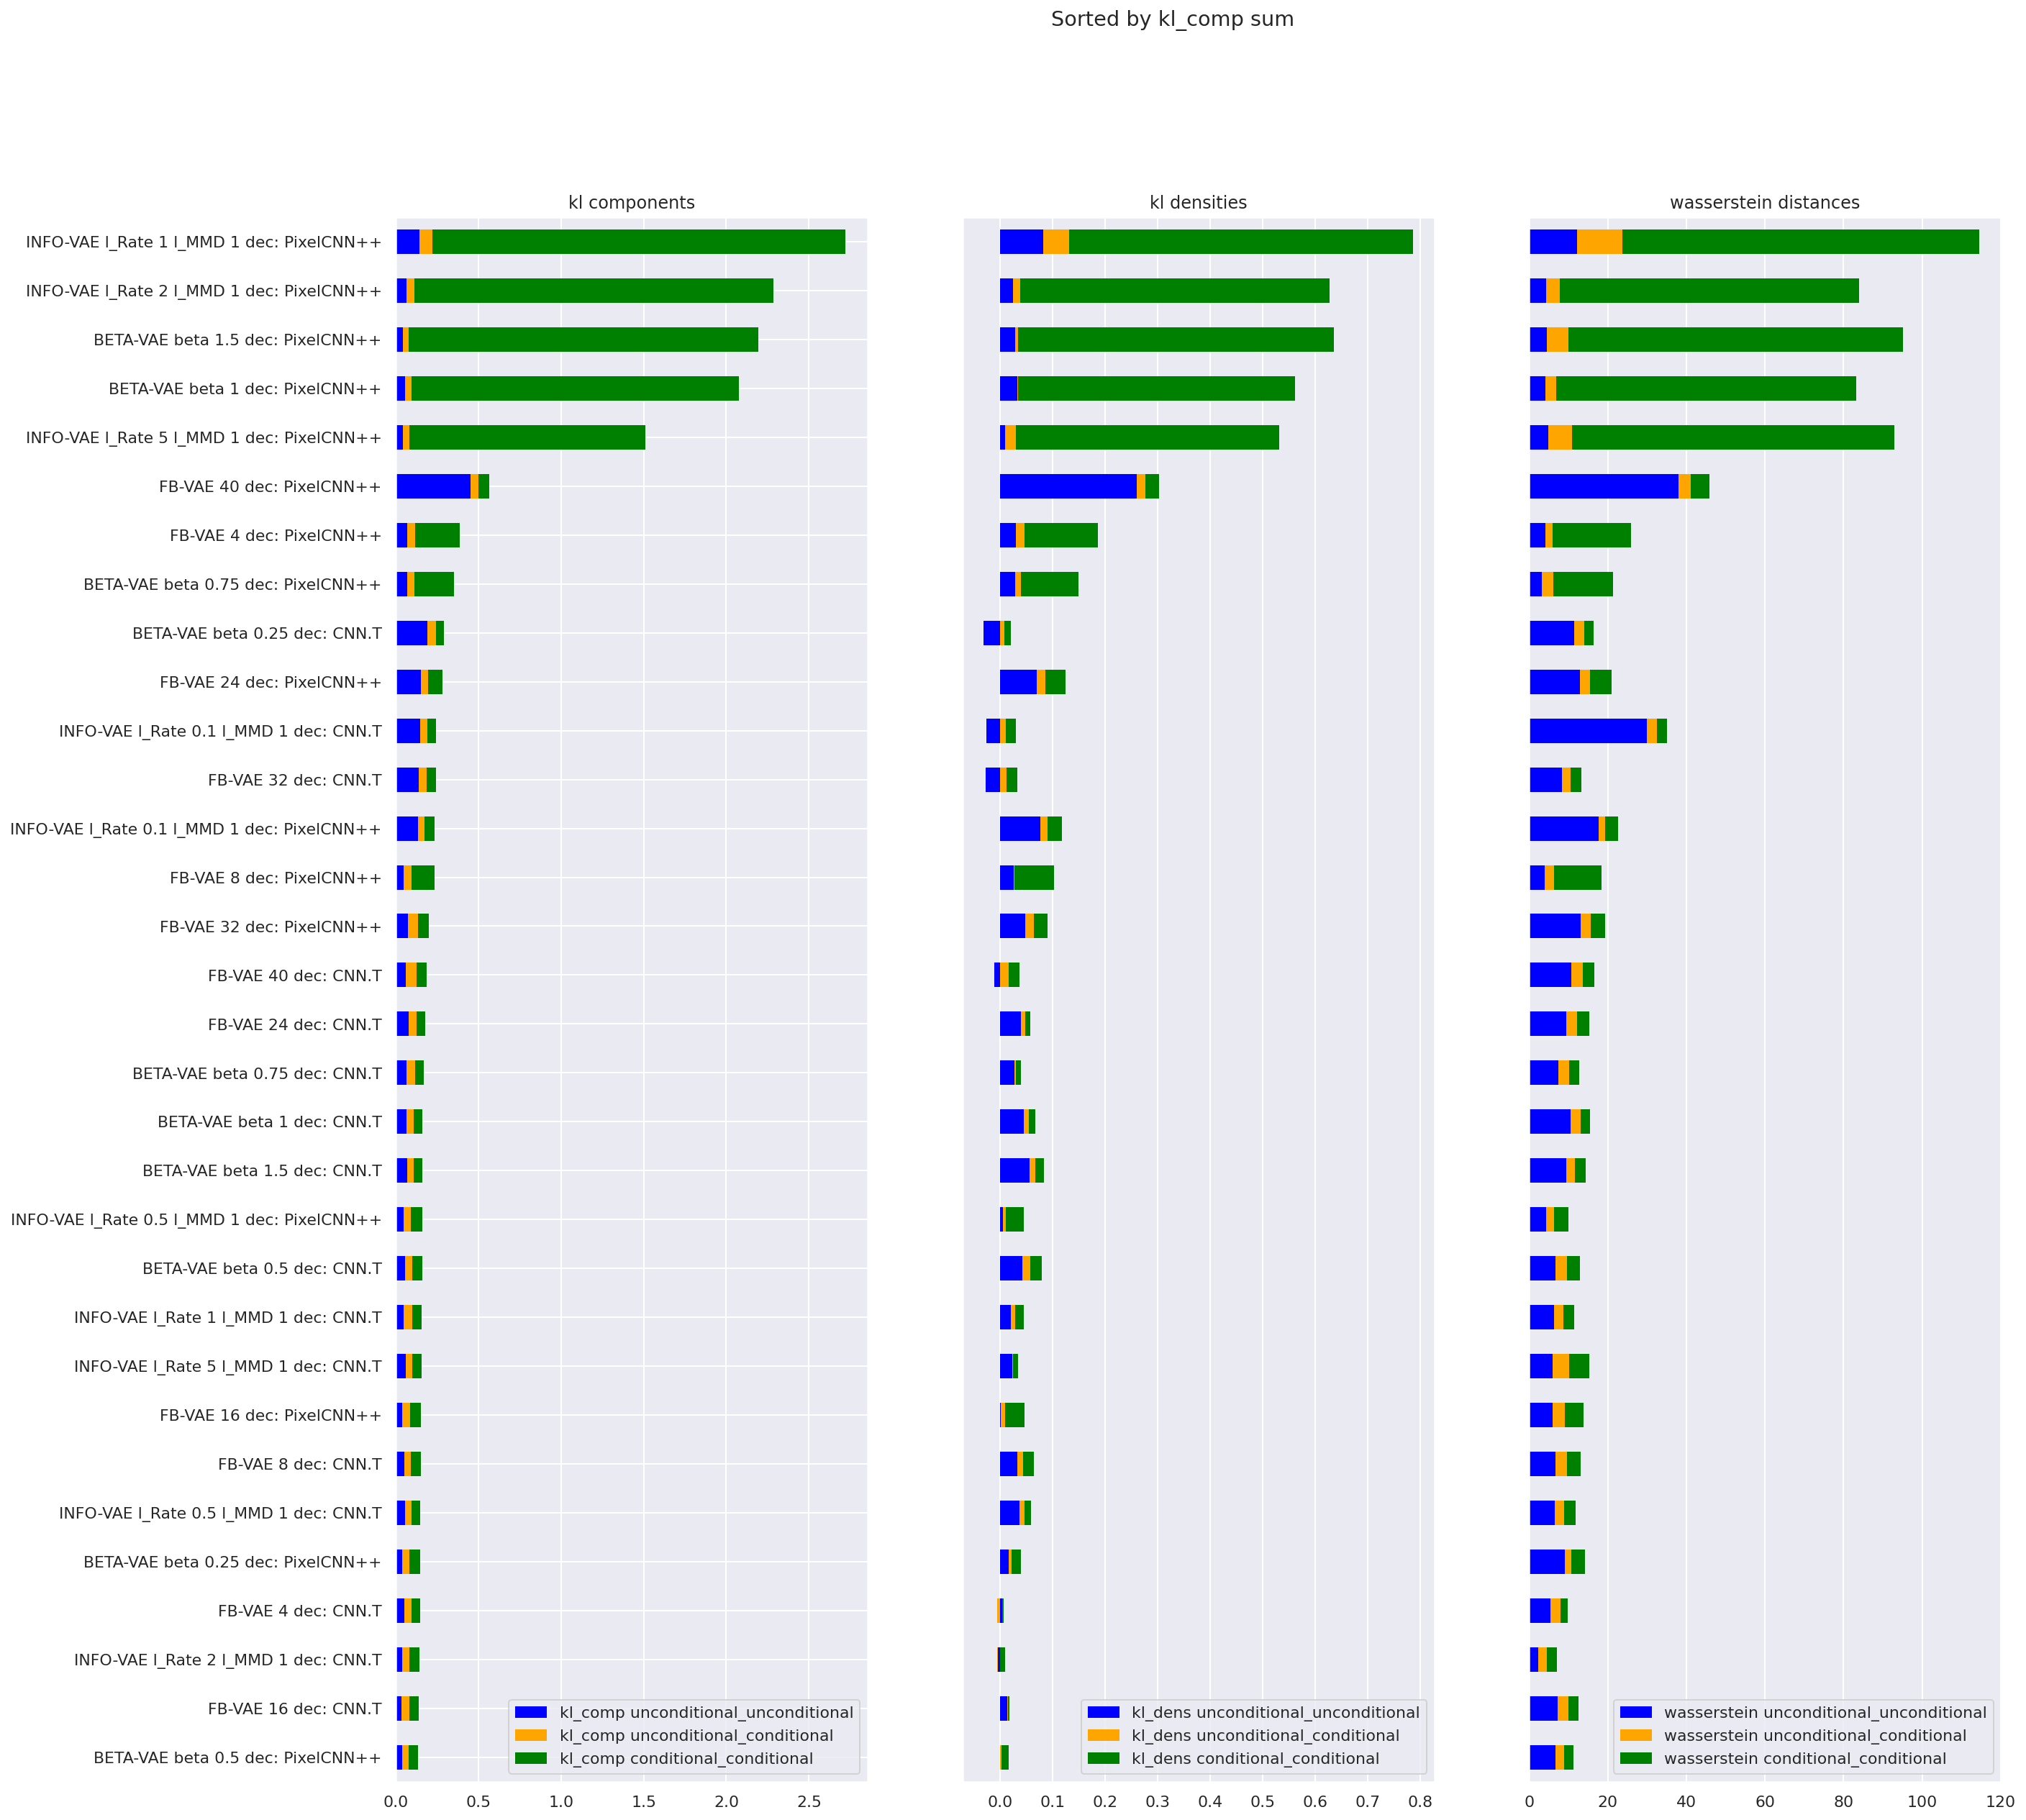

In [27]:
SORT_ON = "kl_comp sum"

all_df = all_df[all_df.index != "data_group"]
all_df_select = all_df[(run_df.beta_beta < 2) & (run_df.l_mmd < 100)]
plot_divergences_data_model_groups(all_df_select, sort_on=SORT_ON, plot_only=None)

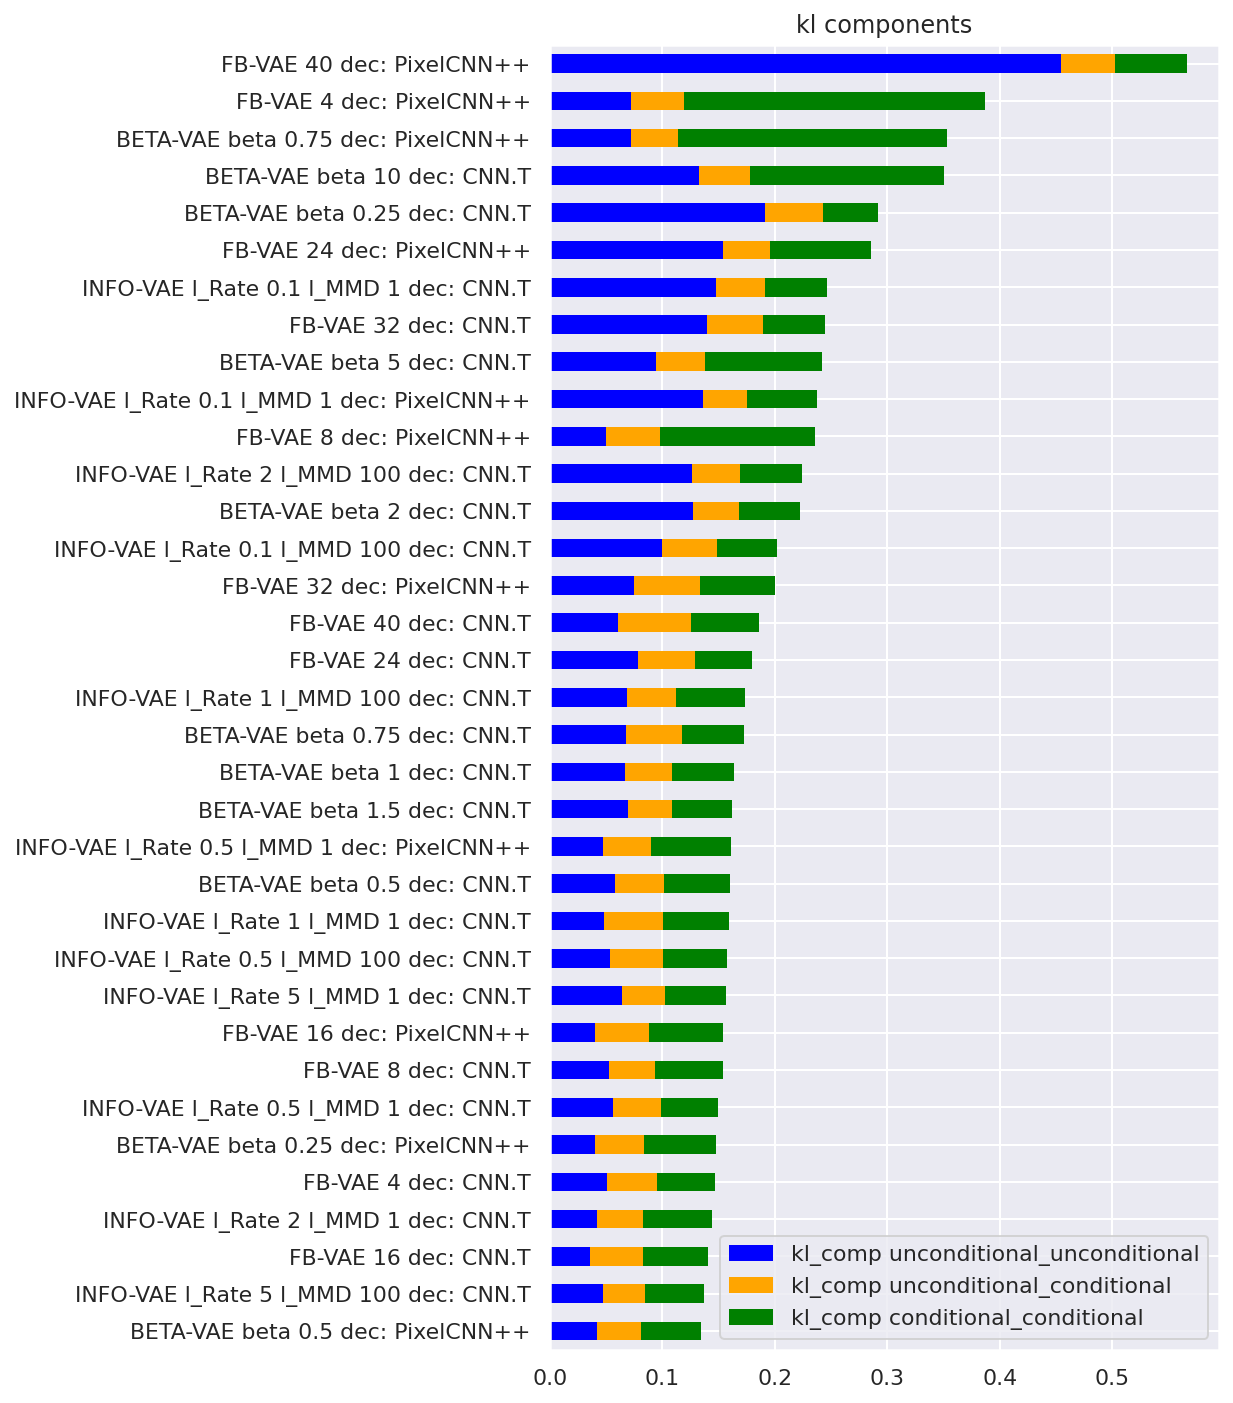

In [34]:
# plot_divergences_data_model_groups(all_df_select, sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))
# plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))
plot_divergences_data_model_groups(all_df[all_df["kl_comp sum"] < 1.0], sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


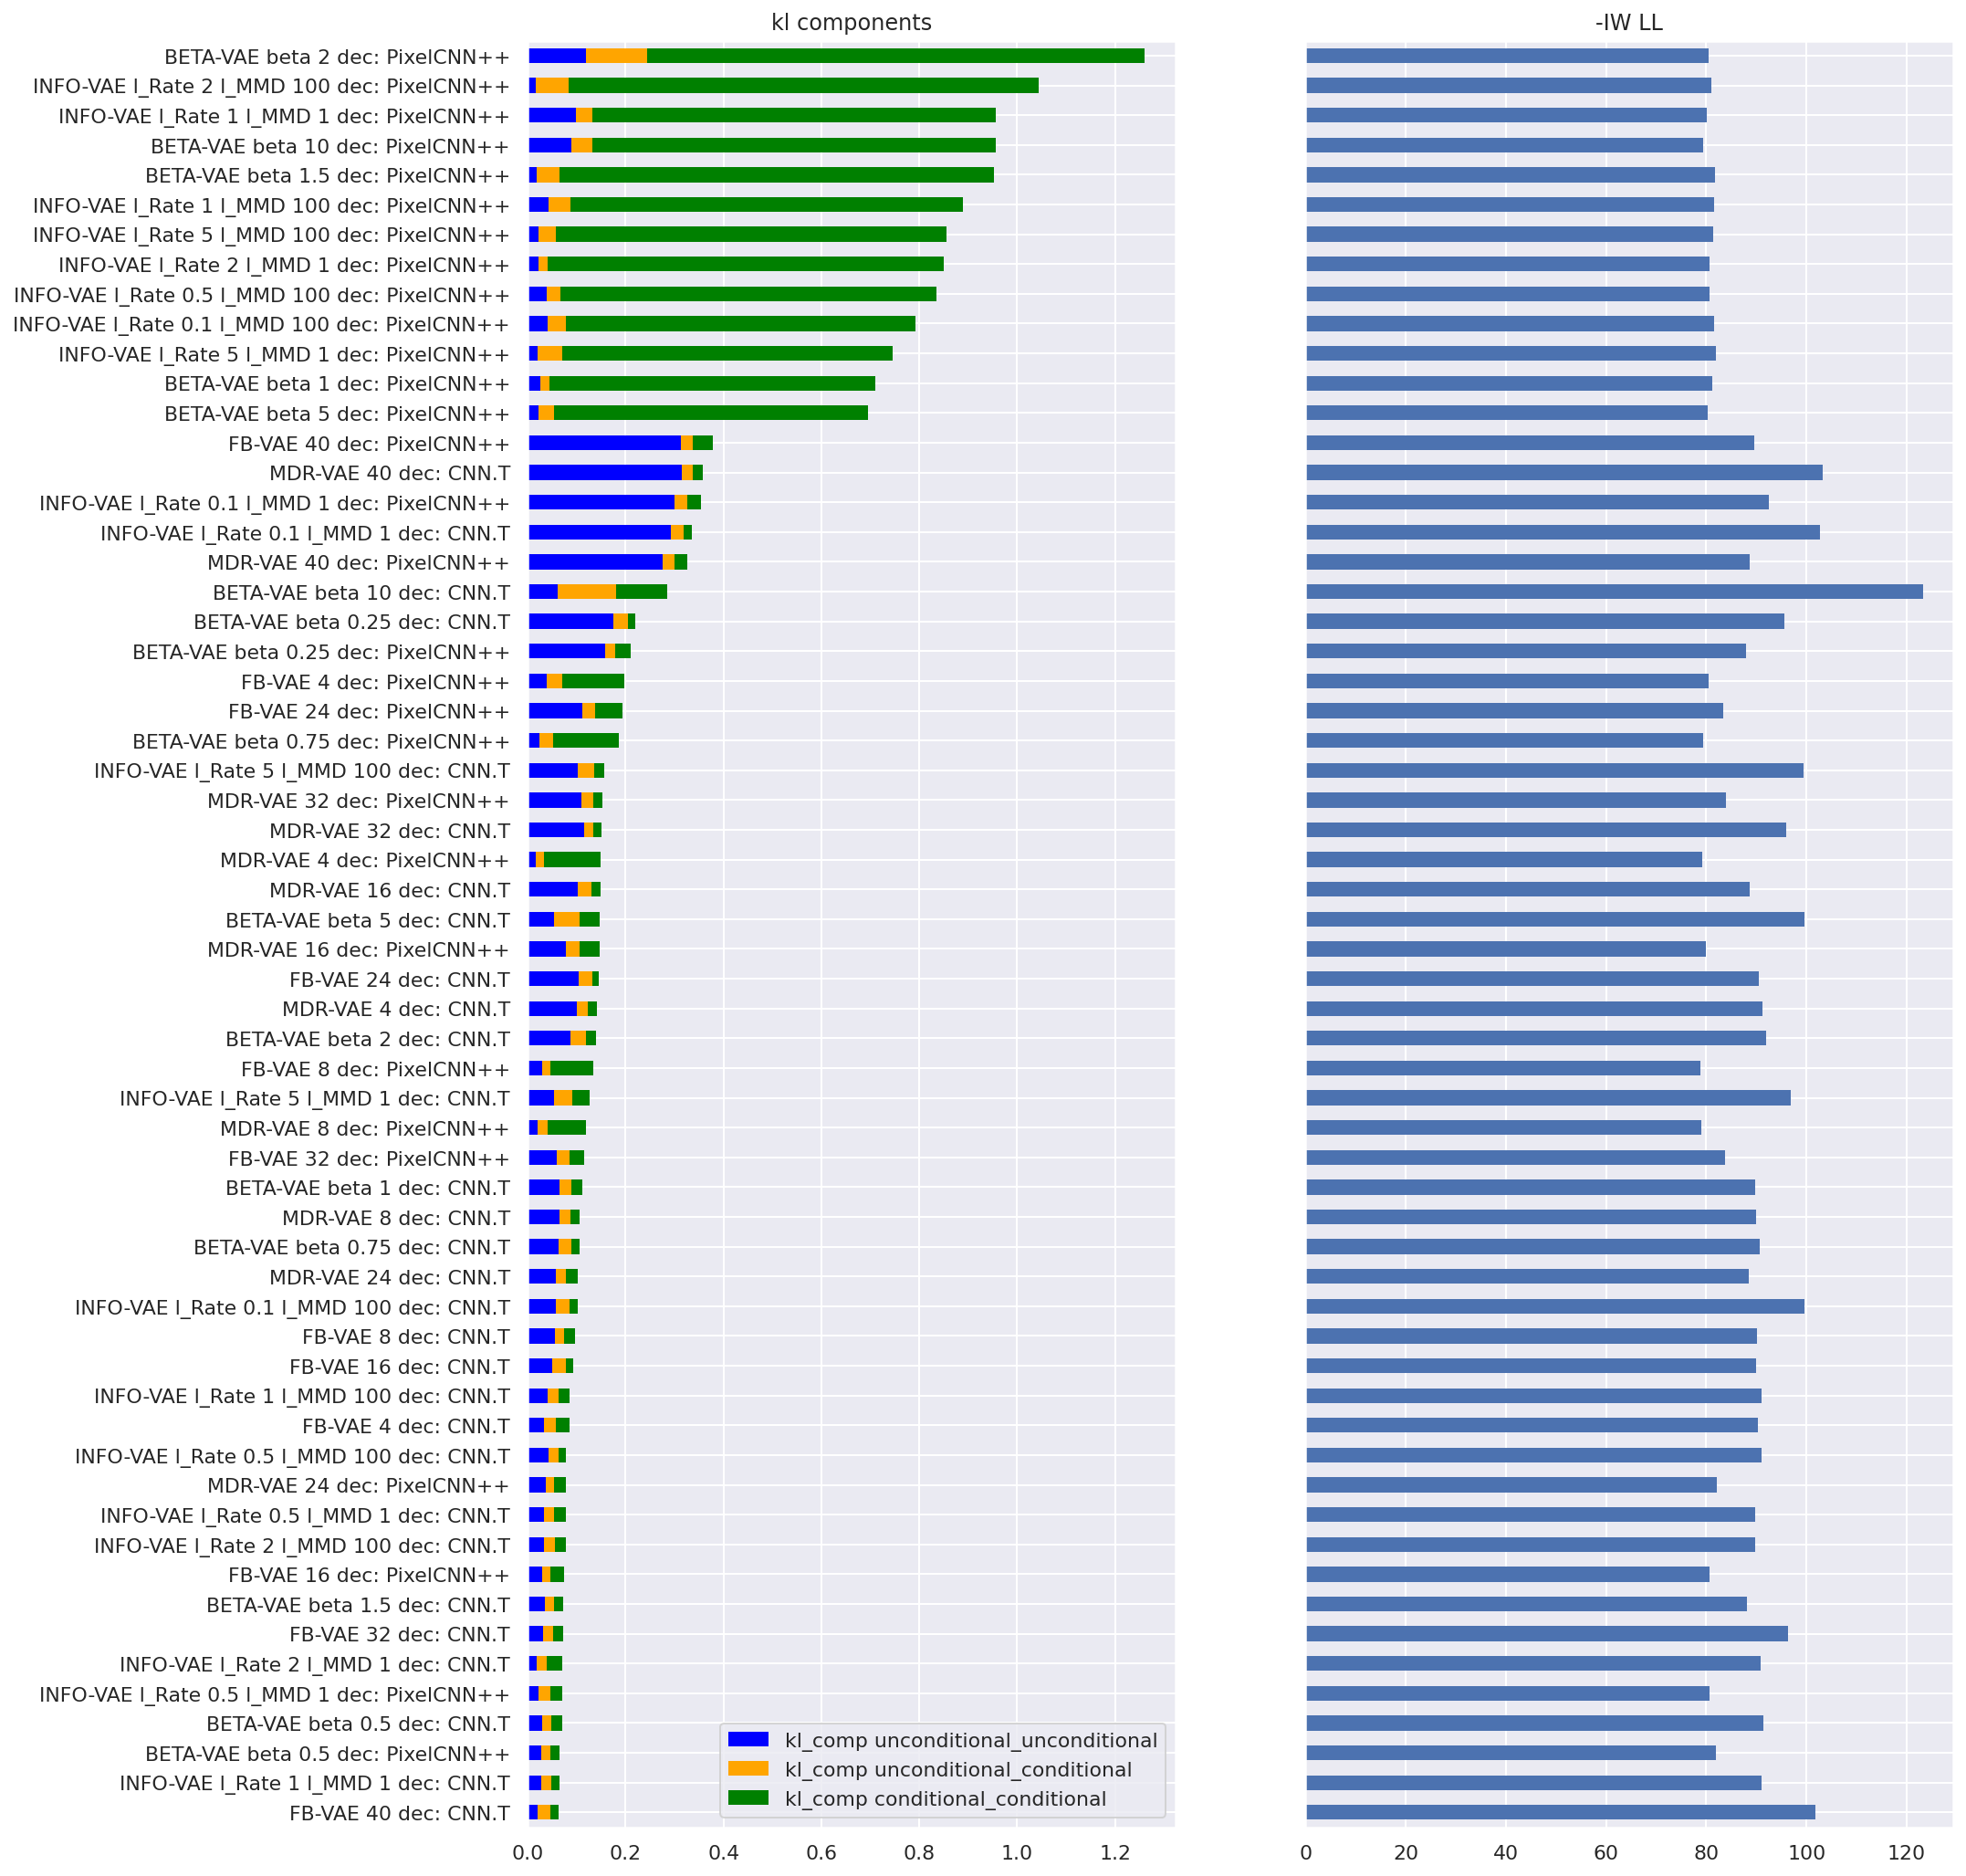

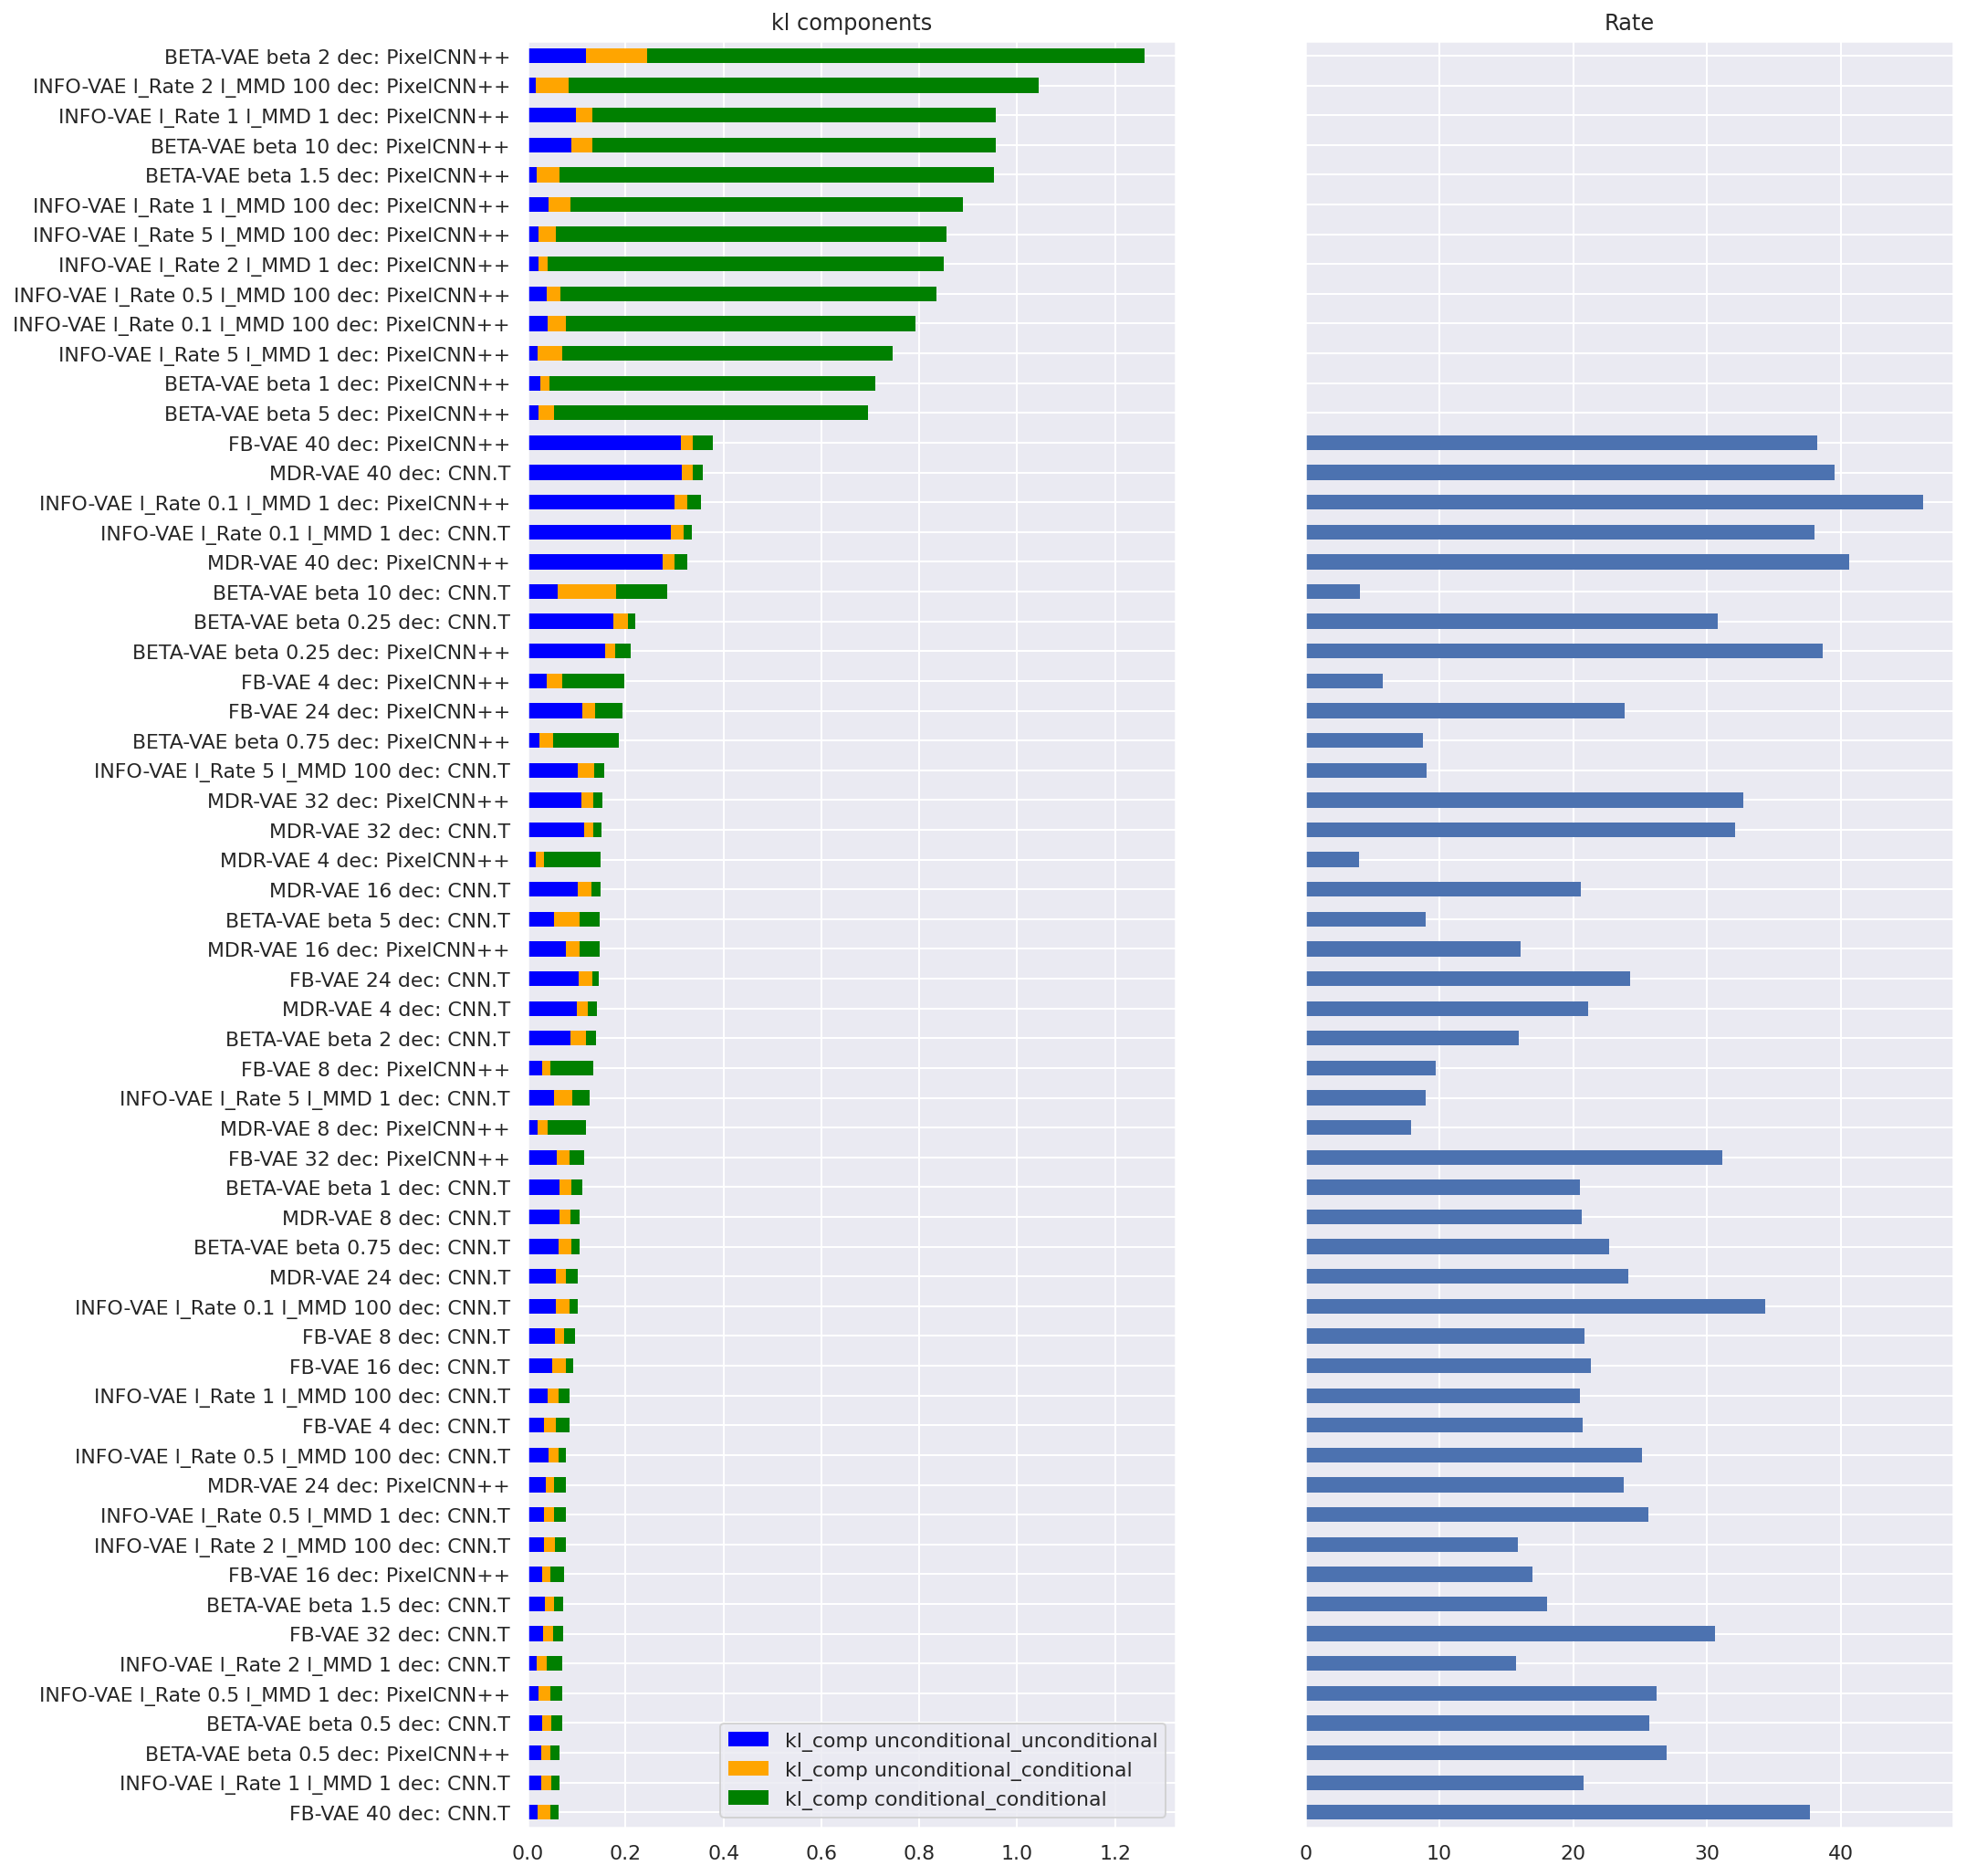

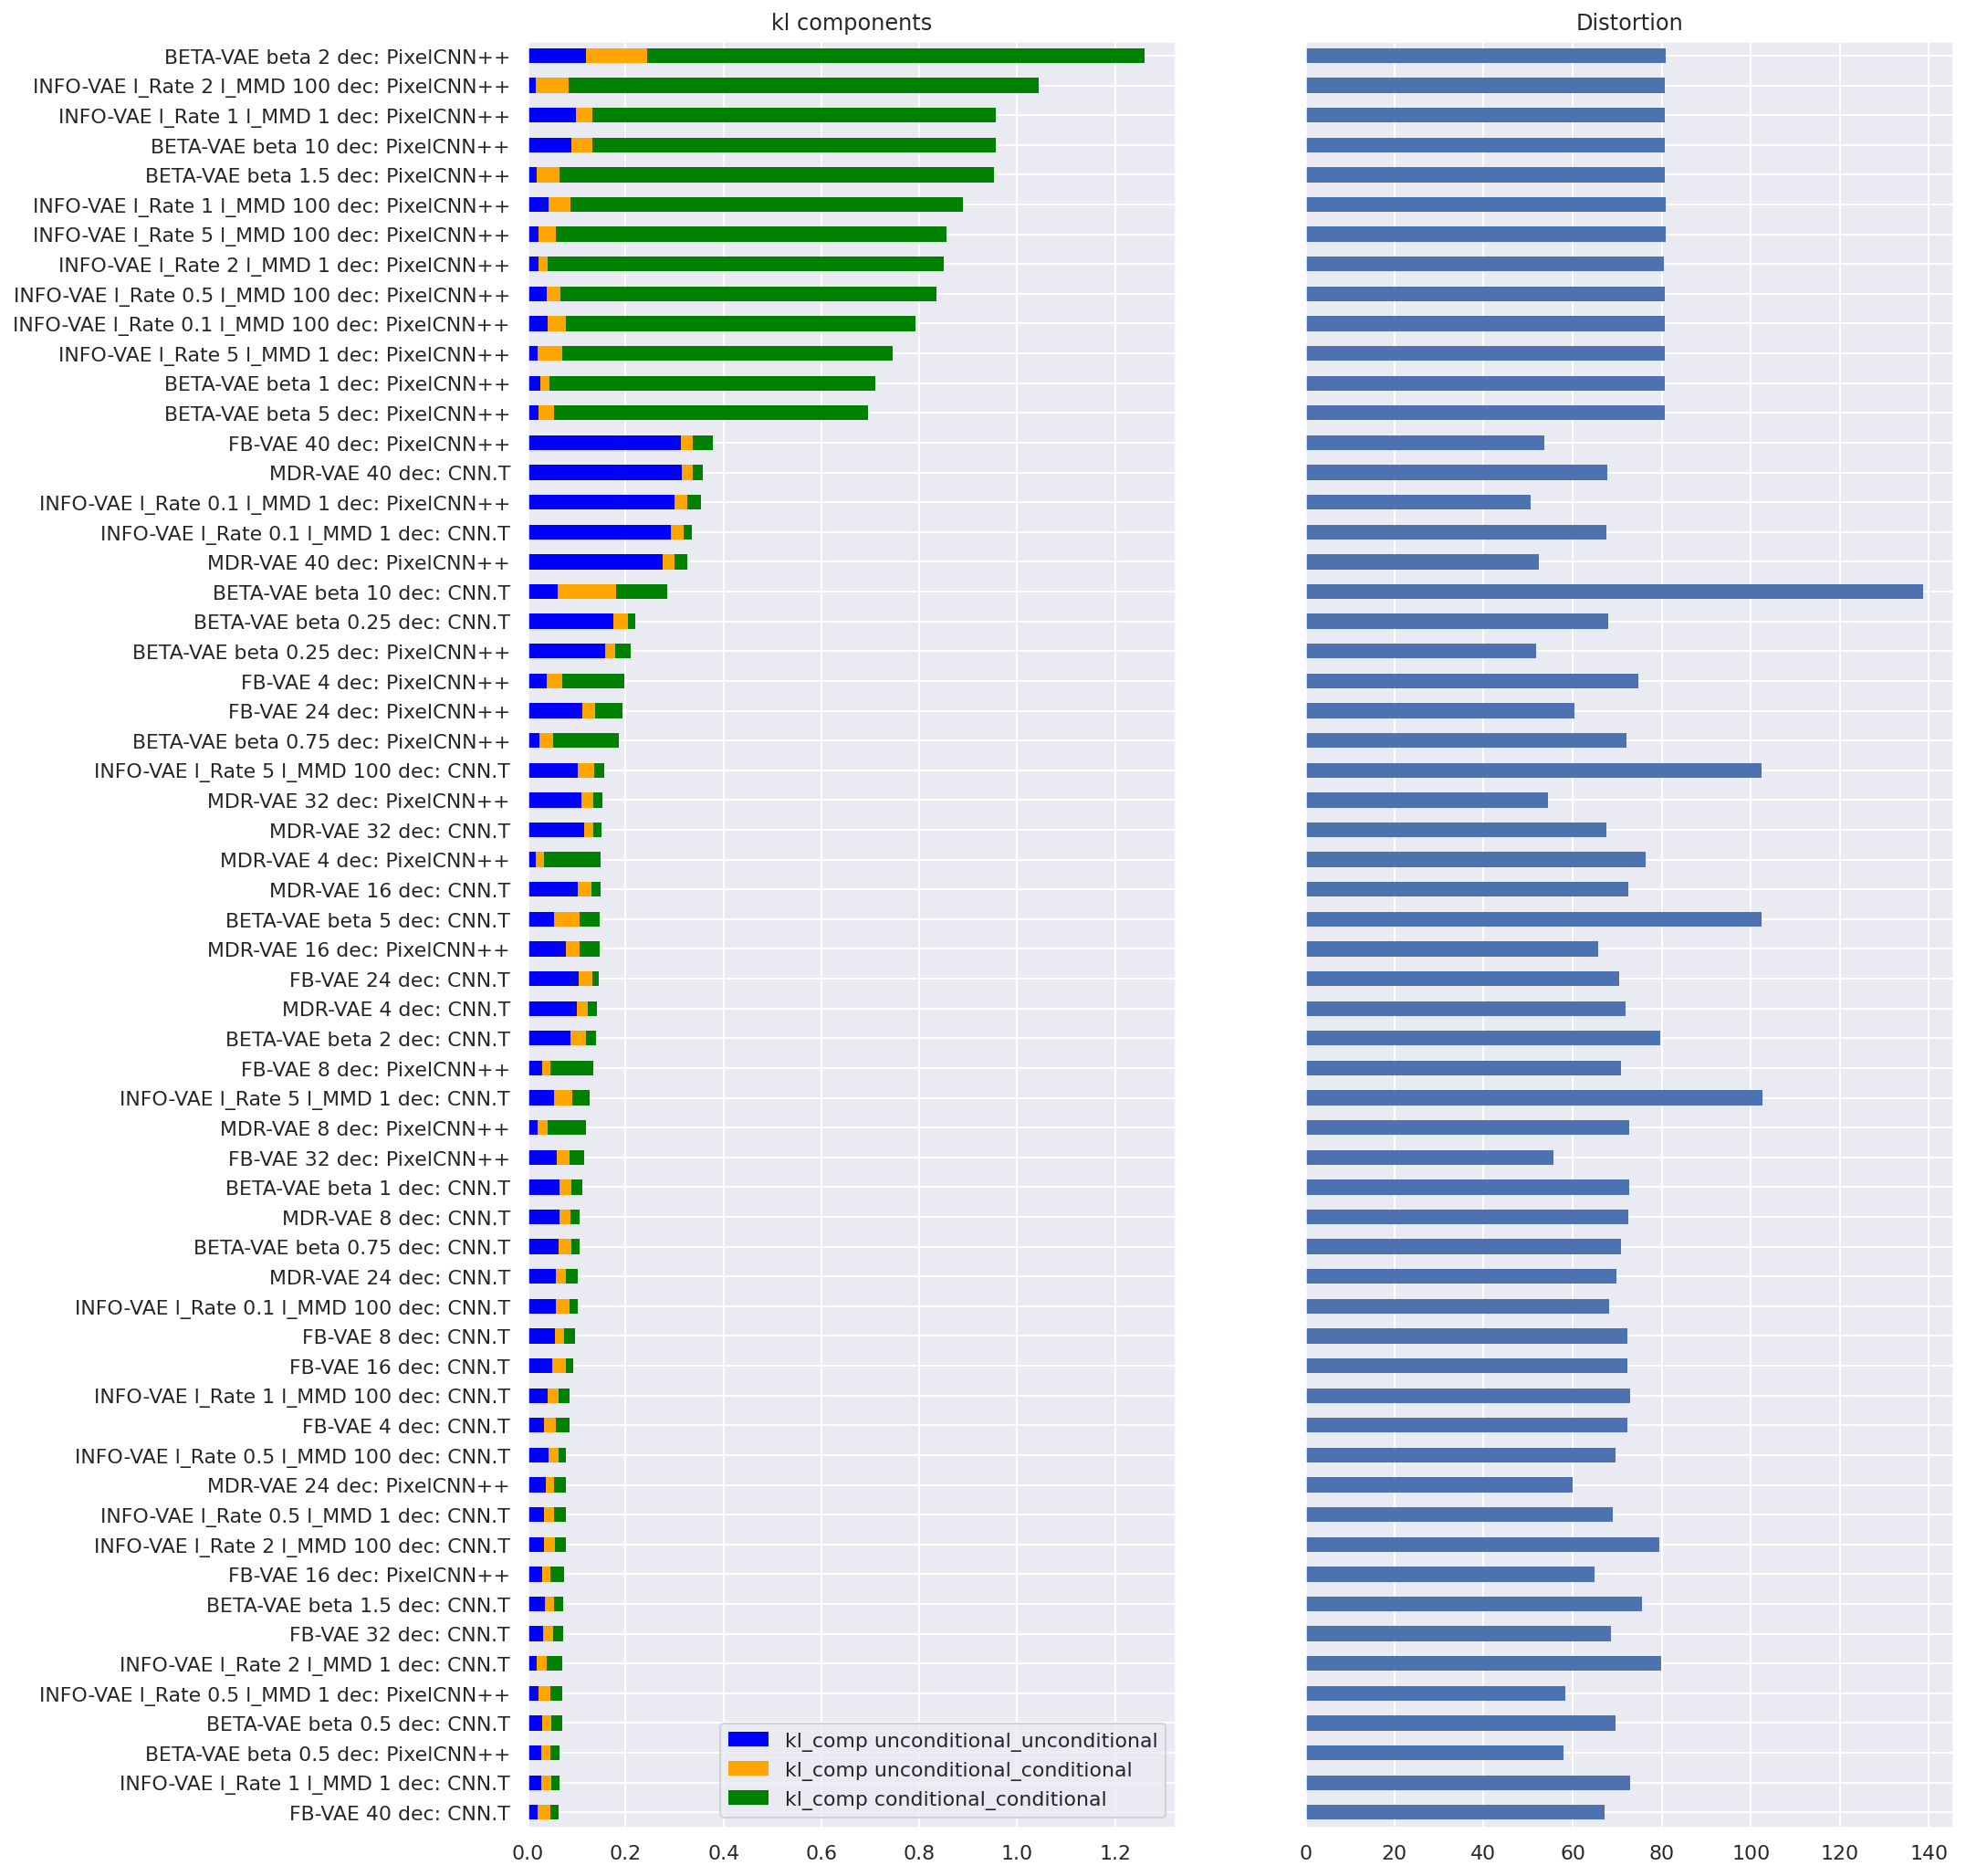

In [74]:
global_stats_df_select["-IW LL"] = - global_stats_df_select["IW LL"]

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="-IW LL", plot_against_name="-IW LL", 
                                                      stat="kl_comp", figsize=(14, 18))

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="kl_prior_post", plot_against_name="Rate", 
                                                      stat="kl_comp", figsize=(14, 18))

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="distortion", plot_against_name="Distortion", 
                                                      stat="kl_comp", figsize=(14, 18))

